## Libraries

In [1]:
import IPython
# IPython.Application.instance().kernel.do_shutdown(True)

# %matplotlib notebook 
#import mpld3
#mpld3.enable_notebook()
# pip install notebook 
# pip install matplotlib neurodsp plotly bokeh scipy PyWavelets imageio ipympl dask pycwt statistics seaborn pandas
#python -m pip install -U scikit-learn
# pip install umap-learn (python<3.11)
#%reset

%matplotlib widget
import os
import sys
import json
import time
import datetime
import pycwt
import statistics
import random
import pickle
#import h5py
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
#import sklearn as sk
import tkinter as tk
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn import decomposition
from sklearn.decomposition import PCA
from tkinter import *
from tkinter import ttk
from sklearn import preprocessing
from datetime import date
import matplotlib.dates as mdates
from matplotlib.colors import LinearSegmentedColormap
from scipy import signal as sg


from neurodsp.rhythm import sliding_window_matching
from neurodsp.utils.download import load_ndsp_data
from neurodsp.plts.rhythm import plot_swm_pattern
from neurodsp.plts.time_series import plot_time_series
from neurodsp.utils import set_random_seed, create_times
# Import listed chormap
from matplotlib.colors import ListedColormap
import matplotlib.dates as md
from matplotlib import colors as mcolors
# Scipy
from scipy import signal
from scipy import ndimage
# TKinter for selecting files
from tkinter import Tk     # from tkinter import Tk for Python 3.x
from tkinter.filedialog import askdirectory
from scipy.stats import zscore


# Add my module to python path
sys.path.append("../")

# Own libraries
from datasets.load import load_setup
from datasets.load import load_matfiles, load_data_multich, load_bsamples
from processing.utils import *
from visualization.graphics.plots import *
from processing.filter import FIR_smooth
from Neurogram import * # Recording, MyWavelet, MyWaveforms

os.environ['KMP_DUPLICATE_LIB_OK']='True'

## **Load data**

In [2]:
time_start_overall = time.time()

In [3]:
#Tk().withdraw()  # keep the root window from appearing
dir_name = ('../datasets/')
#path = askdirectory(initialdir=dir_name, title="Select directory where data are stored")
#path = '../datasets/cambridge/recording/Chronic_VN/rat5&6/day1_Tues/recording_230718_111958'

run_first_time = True
map_path = '../datasets/map_linear.csv' # 
#map_path = 'C:/Users/ampar/Cambridge University Dropbox/Amparo Güemes/Datasets/recording/Cambridge/Chronic VN/map_array_newFFC_newPCB_spiral.csv' #map_array_newFFC_newPCB: 3 branches #map_array_badFFC.csv' # First set, bad FFC, not sure the mapping is correct

In [4]:
time_start = time.time()


# Configure loading
load_raw= True # vs filtered
load_from_file=True  # True: pre-saved file vs multiple rhs
downsample = 1 # Chronic recordings from VN sampled at 20KHz    

# Start and dur in samples (multiply by freq if needed)
start_min= 0 #80                   
dur_min= 40# 1-0   #0 = whole recording                 
port = 'Port B' #

with open("%s/day.txt"%path, "r") as f:
    day = f.read()
#day = 'Day4'
print(port)

#For E1 and E2 fs = 30000
# Rest fs = 20000
fs = 20000
start=fs*60*start_min   #CHANGE FS!!!
if dur_min == 0:
    dur= None 
else: 
    dur = fs*60*dur_min       
    
if load_raw:
    # Load original raw pkl/parquet
    record = Recording.open_record(path, start=start, dur=dur, 
                                   load_from_file=load_from_file, 
                                   load_multiple_files=True,
                                   downsample=downsample,
                                   port=port  ,  # Select recording port
                                   map_path=map_path,
                                   day=day,
                                   verbose=0)
else:
    # Load filtered pkl
    filepath = askopenfile(initialdir=path, title="Select previously stored data file", 
                                filetypes=(   [("Pickle Files", "*.pkl"), 
                                              ("Parquet Files", "*.parquet"),
                                              ("All Files", "*.*")]))  # Add more file types if needed
    try:
        record = pd.read_pickle(filepath.name)
    except: 
        record = pd.read_parquet(filepath.name) # 
    print(record.recording)
    record.recording.name = 'HF_filtered' # Change name

record.channels = 'all' #'5, 24, 26, 27, 28' # # OldFFC:     NewFFC: 5, 20, 24, 26, 27, 28

print("Time elapsed in loading: {} seconds".format(time.time()-time_start)) 


Port B
C:/Users/ampar/Ag2239 Dropbox/Amparo Güemes/Datasets/recording/Cambridge/Epilepsy - pilot/Epilepsy-R11-SD-4.5mm-control/rec_250617_134113
Loading from file C:/Users/ampar/Ag2239 Dropbox/Amparo Güemes/Datasets/recording/Cambridge/Epilepsy - pilot/Epilepsy-R11-SD-4.5mm-control/rec_250617_134113/rec_250617_134113_154413_Port B.parquet
---------------
                                ch_16      ch_17      ch_18   ch_19  \
time                                                                  
1970-01-01 00:00:00.000000 -31.004999 -19.889999 -21.254999 -28.080   
1970-01-01 00:00:00.000050  -5.070000  -5.460000  -8.775000 -13.065   
1970-01-01 00:00:00.000100   7.410000   4.095000   2.925000  -4.290   
1970-01-01 00:00:00.000150   5.265000   0.975000  -1.365000  -2.730   
1970-01-01 00:00:00.000200   7.605000   7.995000  -2.145000   6.435   
...                               ...        ...        ...     ...   
1970-01-01 02:03:03.698950   3.120000  -2.535000  -2.535000  -2.340   
1970

In [7]:
save_figure = True

# Create directory to save figures
if not os.path.exists('%s/figures/' %(path)):
    os.makedirs('%s/figures/' %(path))
    
# Get current time for saving (avoid overwriting)
now = datetime.datetime.now()
current_time = now.strftime("%d%m%Y_%H%M%S")


## **Configuration**

###  General configuration  


#### Options list

In [8]:
options_filter = [
    "None", 
    "butter", 
    "fir"]                # Binomial Weighted Average Filter

options_detection = [
    "get_spikes_threshCrossing", # Ojo: get_spikes_threshCrossing needs detects also cardiac 
                                     # spikes, so use cardiac_window. This method is slower
    "get_spikes_method",         # Python implemented get_spikes() method. Faster
    "so_cfar"]                    # Smallest of constant false-alarm rate filter

options_threshold = [
    "positive",
    "negative", 
    "both_thresh"]
sys.exit()

SystemExit: 

#### Channel seletion

In [9]:
record.channels = [16,17,18,19,20,21,22,23] #E9, E10, E11

# Configure
group = 'HR'
config_text = []
record.apply_filter = options_filter[1]    
record.detect_method = options_detection[2]                                    
record.thresh_type = options_threshold[0]

record.path = path  
config_text = ['Load_from_file %s' %load_from_file, 'Filter: %s'%record.apply_filter, 'Detection: %s'%record.detect_method, 'Threhold type: %s'%record.thresh_type, 'Channels: %s' %record.channels, 'Downsampling: %s' %downsample]
config_text.append('Port %s' %(port))
config_text.append('Start %s, Dur: %s' %(start,dur))
config_text.append('Channels: %s' %record.channels)

print('SELECTED GENERAL CONFIGURATION:')
print('Filter: %s'%record.apply_filter)
print('Detection: %s'%record.detect_method)
print('Threhold type: %s'%record.thresh_type)
print('Channels: %s' %record.channels)   # Intan channels (0-31)
print('-------------------------------------')

record.select_channels(record.channels) # keep_ch_loc=True if we want to display following the map. Otherwise follow the order provided by selected channels.
print('map_array: %s' %record.map_array)     #1D array with the corresponding intan channels (0-31) for linear electrode device (1-32 electrodes): map_array[0] is intan channel corresponding to electrode 1
print('ch_loc: %s' %record.ch_loc)           #[list of int] list with electrodes locations corresponding to the selected intan channels (inverse of map_array: ch_loc[0] is electrode corresponding to intan ch0 )
print('filter_ch %s' %record.filter_ch)      #[list of string] list with the selected intan channels in string mode (starting in 'ch_')
print('Z_magnitude %s' %record.Z_magnitude)  # Impedance of selected intan channels
#print('Intan channels: %s' %record.information['intan_ch'])
#sys.exit()

SELECTED GENERAL CONFIGURATION:
Filter: butter
Detection: so_cfar
Threhold type: positive
Channels: [16, 17, 18, 19, 20, 21, 22, 23]
-------------------------------------
[16, 17, 18, 19, 20, 21, 22, 23]
[16, 17, 18, 19, 20, 21, 22, 23]
map_array: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31]
ch_loc: [17, 18, 19, 20, 21, 22, 23, 24]
filter_ch ['ch_16', 'ch_17', 'ch_18', 'ch_19', 'ch_20', 'ch_21', 'ch_22', 'ch_23']
Z_magnitude [15.9109501953125, 15.5384248046875, 13.8032744140625, 13.6118583984375, 12.8799794921875, 14.1468369140625, 11.5071591796875, 12.644806640625]


In [10]:
record.channels

[16, 17, 18, 19, 20, 21, 22, 23]

In [11]:
# Configure 
topo_plot = "SC_topo"      # "SC_topo" "rectangular_topo"
record.num_rows = len(record.filter_ch) #int(round(len(record.filter_ch)/2)) # round(n_components/2) #8    # 1
record.num_columns = 1#int(len(record.filter_ch)-round(len(record.filter_ch)/2))+1 # 2 #4     # 1

# *Check that number of channels is less or equal to num_rows x num_columns for visualization
if (len(record.ch_loc)>(record.num_rows*record.num_columns)):
    print("The number of channels exceeds the positions for visualization. Check the number of rows and columns")
    sys.exit()

# Select channel to plot
plot_ch = int(record.channels[0])                 # int(record.filter_ch[0][-2:])  # Get first channel to visualise

print(plot_ch)
print(record.num_rows)
print(record.num_columns)
config_text.append('Visualization options: %sx%s, topo_plot: %s, save_figure: %s' %(record.num_rows, record.num_columns, topo_plot, save_figure))

16
8
1


- When analyzing a signal sampled at 100 Hz, a center frequency of 1.0 corresponds to ~100 Hz at scale = 1. This is above the Nyquist rate of 50 Hz, so for this particular wavelet, one would analyze a signal using scales >= 2.
- Larger scales correspond to stretching of the wavelet. For example, at scale=10 the wavelet is stretched by a factor of 10, making it sensitive to lower frequencies in the signal.

----------------------------------------------------------------------------------------

## Pre-processing                                            


In [13]:
record.original.head()

ch_16      ch_17      ch_18   ch_19  \
time                                                                  
1970-01-01 00:00:00.000000 -31.004999 -19.889999 -21.254999 -28.080   
1970-01-01 00:00:00.000050  -5.070000  -5.460000  -8.775000 -13.065   
1970-01-01 00:00:00.000100   7.410000   4.095000   2.925000  -4.290   
1970-01-01 00:00:00.000150   5.265000   0.975000  -1.365000  -2.730   
1970-01-01 00:00:00.000200   7.605000   7.995000  -2.145000   6.435   

                                ch_20      ch_21      ch_22      ch_23  \
time                                                                     
1970-01-01 00:00:00.000000 -32.174999 -42.314999 -18.915001  -0.975000   
1970-01-01 00:00:00.000050  -3.120000  -7.995000   5.265000  24.180000   
1970-01-01 00:00:00.000100   5.070000  -1.950000   9.360000  24.959999   
1970-01-01 00:00:00.000150   3.900000  -7.995000   1.560000  24.959999   
1970-01-01 00:00:00.000200   4.875000  -7.410000   8.775000  24.764999   

                            seconds  
time                                 
1970-01-01 00:00:00.000000  0.00000  
1970-01-01 00:00:00.000050  0.00005  
1970-01-01 00:00:00.000100  0.00010  
1970-01-01 00:00:00.000150  0.00015  
1970-01-01 00:00:00.000200  0.00020

### Plot recording signal

### Filtering
- Done: optimised filtering so that it uses second-order-cascade (sos). See method filter() in Neurogram.py for more details*

#### Bandwidth filter

In [14]:
# Configure
filt_config = {
    'W': [300, 2000], #[300, 2000], #[4950], #   [50] lowpass for HR,  [400, 8000], 4950 if fs is 10000 (needs to be <fs/2 per Nyquist)
    'None': {},
    'butter': {
            'N': 4,                # The order of the filter
            'btype': 'bandpass', #'bandpass', #'hp'  #'lowpass'     # The type of filter.
            'fs': record.fs,
    },
    'butter_non_causal': {   # Not valid for real time applications
        'N': 4,                # The order of the filter
        'btype': 'bandpass', #'bandpass', #'hp'  #'lowpass'     # The type of filter.
    },
    'fir': {
            'n': 4,
    },
    'notch': {
            'quality_factor': 30,
    },
}

filt_config['butter']['Wn'] = filt_config['W']
#filt_config['butter']['fs'] = record.fs

config_text.append('filt_config: %s' %json.dumps(filt_config))

##### Apply filter

In [15]:
if load_raw:
    time_start = time.time()

    # If applied clean_df and have Nan values (clean then filter)
    if record.recording.name == 'clean':
        kargs = filt_config[record.apply_filter]
        kargs['fs'] = record.fs
        sos = sg.butter(**kargs, output='sos')  # Coefficients for SOS filter

        def apply_butterworth_filter(df, sos, channels):
            # Create a copy of the DataFrame to avoid modifying the original data
            df_filtered = df.copy()

            # Initialize filter state with sosfilt_zi
            zi = sg.sosfilt_zi(sos)

            # Apply the filter and update NaN values inside the loop
            for channel in channels:
                mask_nan = df_filtered[channel].isna()
                df_filtered[channel], zi = sg.sosfilt(sos, df_filtered[channel].fillna(0.0), zi=zi)
                df_filtered[channel][mask_nan] = np.nan
                nan_counts = df_filtered[channel].isna().sum()
                #print("Number of NaN values in each column:")
                #print(nan_counts)

            return df_filtered

        # Apply the Butterworth filter to the specified channels
        record.filtered = apply_butterworth_filter(record.recording, sos, record.filter_ch)
    else:
        signal2filter = record.original ###record.original #record.recording
        config_text.append('signal2filter: %s' %signal2filter.name)
        record.filter(signal2filter, record.apply_filter, **filt_config[record.apply_filter])
        # Change from float64 to float 16
        record.filtered = convertDfType(record.filtered, typeFloat='float32')
        #print(record.filtered.dtypes)
    print("Time elapsed: {} seconds".format(time.time()-time_start))
    record.recording=record.filtered
    record.recording.name = 'filtered'

Applying butter
{'N': 4, 'btype': 'bandpass', 'fs': 20000.0, 'Wn': [300, 2000]}
Time elapsed: 10.509885549545288 seconds


##### Plot filtered signal - Check Notion spectrogram for details

plotting device ch 16
plotting device ch 17
plotting device ch 18
plotting device ch 19
plotting device ch 20
plotting device ch 21
plotting device ch 22
plotting device ch 23


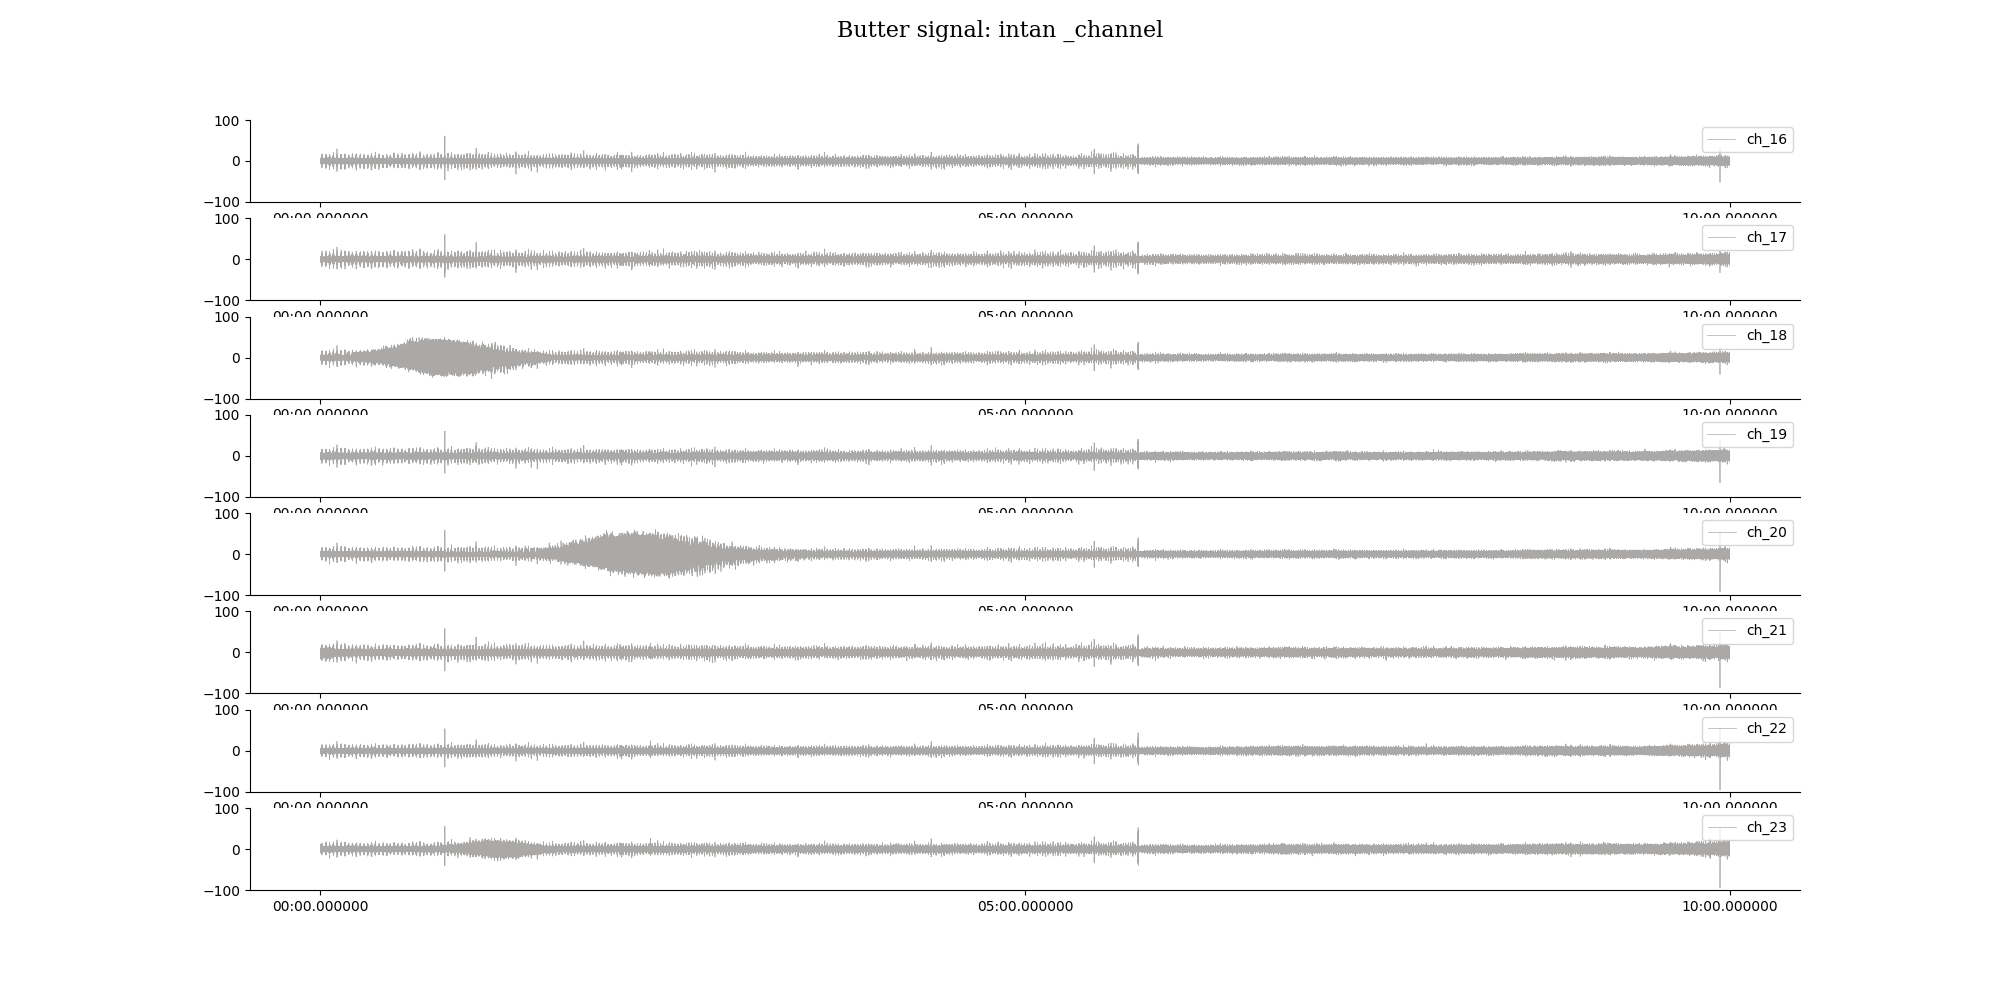

In [16]:
if load_raw:
    current_time = now.strftime("%d%m%Y_%H%M%S")
    nperseg=512
    no_label = False
    cmap = 'gist_ncar' # 'nipy_spectral'
    text_label = 'Filtered'
    text = 'Channels after %s filtering'%record.apply_filter
    
    if filt_config['butter']['btype'] == 'lowpass':
        freq_max = filt_config['W'][0]
        textf = 'LF'
        colorbar_ticks_filt=[20,0,-20,-40]
    else:
        freq_max = filt_config['W'][1] #2000 #chronic: 4000
        textf = 'HF'
        colorbar_ticks_filt= [5, 0, -50, -100, -150, -200] # in vivo: [5, 0, -50, -100, -150, -200]#, -250] #[-10, -35]  ex vivo: [-50, -100]
    
    #'''
    record.plot_signal(record.filtered.loc[record.filtered.index[int((start_min-start_min)*60*record.fs)]:record.filtered.index[int((start_min-start_min)*60*record.fs)] + pd.Timedelta(seconds=(10*60))],
                       plot_ch,record.num_rows,record.num_columns, 
                       channels=record.channels, text_label=text_label, text_title='Butter signal: intan _channel', ylim=[-100,100],
                       figsize=(20, 10), no_label=no_label, savefigpath='%s/figures/%s_ch%s_%s_lab%s-%s.svg' %(record.path, port,plot_ch, textf, no_label, current_time),
                       show_plot=True)
    #'''
    #for plot_ch in record.column_ch:
     
    #sys.exit()

#### Notch filtering 

In [ ]:
if load_raw:
    time_start = time.time()
    freq_notch =  [1950] # range(350, 2000, 100) #5000#range(50, 400, 100) #2000 [1650] #[350, 450, 550, 1550] range(450, 4000, 100)
    for n in freq_notch:
        filt_config['notch']['notch_freq'] = n
        record.filter(record.filtered, 'notch', **filt_config['notch'])
    print("Time elapsed: {} seconds".format(time.time()-time_start))
    config_text.append('notch_filtered:applied')
    # Change from float64 to float 16
    record.filtered = convertDfType(record.filtered, typeFloat='float32')
    record.recording=record.filtered
    record.recording.name = 'filtered'

##### Plot filtered signal

In [ ]:
if load_raw:
    ylim = [-400, 400]
    no_label = False
    text_label = 'Filtered'
    text = 'Channels after %s filtering'%'notch'
    colorbar_ticks= [15, 0, -50, -100, -150, -200]
    cmap = 'gist_ncar' # 'nipy_spectral'
    nperseg = 512
    freq_max = 2000
    
    '''
    record.plot_signal(record.filtered, plot_ch,,record.num_rows,record.num_columns, 
                channels=record.channels, text_label=text_label, text_title='Butter signal: channel position in device', ylim=[-500,1500],
                       figsize=(10, 10), savefigpath='%s/figures/%s_%s_allfilt-%s.png' %(record.path, port,group, current_time),
                       show_plot=True)
    '''
    record.plot_freq_content(record.recording, int(plot_ch), ylim=ylim, nperseg=nperseg, max_freq=freq_max, dtformat='%H:%M:%S',
                             figsize=(10, 10), savefigpath='%s/figures/%s_ch%s_%s_notch_lab%s-%s.svg' %(record.path, port,plot_ch, 'notch', no_label, current_time), 
                             show=True, cmap=cmap, colorbar_ticks=colorbar_ticks, no_label=no_label)  
    sys.exit()
    

## Neural checks for single channel

In [17]:
window_ref = 'whole'

#start_min = 70
end_min = (start_min+dur_min)

# Select window within period (using same time index as original, e.g. min 1 from raw = min 1 in this window definition
start_minute= start_min # 80 #30                   
end_minute = end_min #end_min # 150 
print(start_minute)
print(end_minute)

# Select the priod of interest
selected_data=record.filtered.iloc[int((start_minute-start_min)*60*record.fs):int((end_minute-start_min)*60*record.fs)]

# Display the first few rows to check
print(selected_data)


0
40
                               ch_16     ch_17     ch_18     ch_19     ch_20  \
time                                                                           
1970-01-01 00:00:00.000000 -0.085568 -0.054893 -0.058660 -0.077496 -0.088797   
1970-01-01 00:00:00.000050 -0.562663 -0.367046 -0.400350 -0.532967 -0.577986   
1970-01-01 00:00:00.000100 -1.689206 -1.124524 -1.257734 -1.710153 -1.722286   
1970-01-01 00:00:00.000150 -3.082139 -2.110845 -2.441651 -3.449450 -3.137240   
1970-01-01 00:00:00.000200 -3.753493 -2.687184 -3.300484 -4.917830 -3.863371   
...                              ...       ...       ...       ...       ...   
1970-01-01 00:39:59.999750 -2.871051 -1.085821  2.423537 -0.458685 -0.677224   
1970-01-01 00:39:59.999800 -3.176864 -1.076061  0.887290 -0.104908 -0.192250   
1970-01-01 00:39:59.999850 -2.924378 -1.148734 -0.705658  0.063692  0.040873   
1970-01-01 00:39:59.999900 -2.213813 -1.283312 -1.917829 -0.041907 -0.089529   
1970-01-01 00:39:59.999950 -1.33995

##### Drop bad channels

In [ ]:
# Drop ceratin channels (identified as not good correlated from corr-spike train
chan = ''

selected_data = selected_data.drop(columns=['ch_19', 'ch_22']) #,'ch_20', 'ch_22']) # L2.D1
record.channels = [ch for ch in record.channels  if ch not in [19, 22]] #,20,22]]
record.filter_ch = [ch for ch in record.filter_ch  if ch not in ['ch_19', 'ch_22']] #,'ch_20', 'ch_22']] # ['ch_%s'%chan]] #, 'ch_19', 'ch_22']]

print(record.channels )

### Referencing

###### No ref

In [ ]:
ref_ch_name ='none' 
references_df = record.filtered

##### Median

The median of nearby channels is used to subtract from each channel in this referencing method. This is a robust statistic, meaning it’s less sensitive to extreme values or outliers compared to the mean. If the artifact has high amplitude in certain channels, median referencing will likely smooth out those outliers and reduce the influence of extreme artifact values.
While this might help reduce the artifact's impact, the channels with a higher amplitude artifact will still carry a larger contribution of the artifact, even after subtraction.

🧠 When to Use Localised CAR (Common Average Referencing)?
✅ If neural signals are locally distributed and global referencing removes meaningful signals.
✅ If different regions of the array pick up different noise sources.
✅ If you want to enhance local spatial contrast without losing wider network activity.

In [18]:
signal = selected_data # original
ref_ch_name ='median' #'mean'#'mean' 'none

if ref_ch_name == 'median':
    print(ref_ch_name)
    #all_ch_list = [col for col in record.original.columns if col.startswith('ch_')]
    all_ch_list = [col for col in record.filter_ch if col.startswith('ch_')] # record.filter_ch ['ch_4', 'ch_11', 'ch_20', 'ch_21']
    print(all_ch_list)
    ref_ch = signal[all_ch_list].median(axis=1)
elif ref_ch_name == 'mean':
    print(ref_ch_name)
    all_ch_list = [col for col in record.filter_ch if col.startswith('ch_')] 
    print(all_ch_list)
    ref_ch = signal[all_ch_list].mean(axis=1)
else:
    ref_ch = signal['ch_%s'%ref_ch_name]  
references_df = signal[record.filter_ch].sub(ref_ch, axis=0)

median
['ch_16', 'ch_17', 'ch_18', 'ch_19', 'ch_20', 'ch_21', 'ch_22', 'ch_23']


In [ ]:
record.filter_ch

##### Laplacian
2️⃣ Laplacian Referencing
🔹 How It Works:
Computes a spatial derivative by subtracting the signal from the average of directly adjacent electrodes (e.g., nearest neighbors).
Enhances localized neural activity by emphasizing differences between an electrode and its neighbors.
🔹 Impact on Neural Signals:
✅ Enhances high-spatial-frequency activity (sharpens local signals).
✅ Suppresses far-field signals and volume conduction effects (useful for isolating specific neural sources).
❌ Can distort low-frequency signals if spacing is uneven or if there are too few neighbors.

📌 Example Use Case:

When you want to highlight local sources and suppress background activity (e.g., distinguishing neural bursts from volume-conducted signals). Pure non-wiegthed Laplacian: The fact that the motion artifact varies across channels suggests that differential referencing methods like Laplacian might highlight these differences and possibly even amplify them, resulting in spurious patterns that mimic true neural signal propagation.

In [ ]:
import numpy as np
import pandas as pd

# Assume `selected_data` is the signal DataFrame with a datetime index
signal = selected_data  
ref_ch_name = 'weighted_laplacian'  # Set the reference channel name

# Step 1: Define correct and available channel orders
wrong_order = record.channels  # The available channels
correct_order = [13, 12, 19, 20, 21, 22, 11, 10]  # Full intended order

# Find the available channels in the correct order
available_channels = [ch for ch in correct_order if ch in wrong_order]
channel_indices = {ch: i for i, ch in enumerate(correct_order)}  # Map channel to position
print("Available channels:", available_channels)

# Step 2: Apply Weighted Laplacian referencing using all available channels
laplacian_references = []

for ch in available_channels:
    print(f'Processing channel {ch}...')
    ch_name = f'ch_{ch}'  # Ensure column names are in the format 'ch_22'
    
    # Find the index of the current channel in correct_order
    current_index = correct_order.index(ch)
    
    # Identify all other available channels and their distances
    neighbors = []
    distances = []
    
    for neighbor in available_channels:
        if neighbor != ch:  # Avoid self-referencing
            neighbors.append(f'ch_{neighbor}')
            distances.append(abs(current_index - correct_order.index(neighbor)))  # Compute spatial distance
    
    # Compute weights: Closer neighbors get higher weights
    distances = np.array(distances)
    weights = 1 / distances  # Inverse of distance
    weights /= weights.sum()  # Normalize so sum(weights) = 1
    
    # Compute weighted reference
    neighbors_data = signal[neighbors]
    weighted_ref = (neighbors_data * weights).sum(axis=1)
    
    # Apply Laplacian referencing (subtract weighted reference from current channel)
    laplacian_references.append(signal[ch_name] - weighted_ref)

# Step 3: Assemble the final DataFrame
laplacian_df = pd.DataFrame(np.array(laplacian_references).T, columns=[f'ch_{ch}' for ch in available_channels])

# Step 4: Keep the same datetime index as the original signal DataFrame
laplacian_df.index = signal.index

# Step 5: Store the Weighted Laplacian-referenced signals
references_df = laplacian_df

# Display the first few rows (optional)
print(references_df.head())


##### Plots

In [ ]:
plot_ch = 29 #record.channels[0]
colorbar_ticks_filt=[-20,-40]
record.plot_freq_content(references_df,int(plot_ch), nperseg=512, max_freq=2000, ylim=[-50,50], dtformat='%H:%M:%S', 
                             figsize=(20, 10), savefigpath='%s/figures/%s_ch%s_%s_%s_%s-%smin-%s.svg' %(record.path,port,plot_ch, window_ref, ref_ch_name, (start_minute), (end_minute), current_time),
                             show=True, cmap='gist_ncar' , colorbar_ticks=colorbar_ticks_filt)    

plotting device ch 16
plotting device ch 17
plotting device ch 18
plotting device ch 19
plotting device ch 20
plotting device ch 21
plotting device ch 22
plotting device ch 23


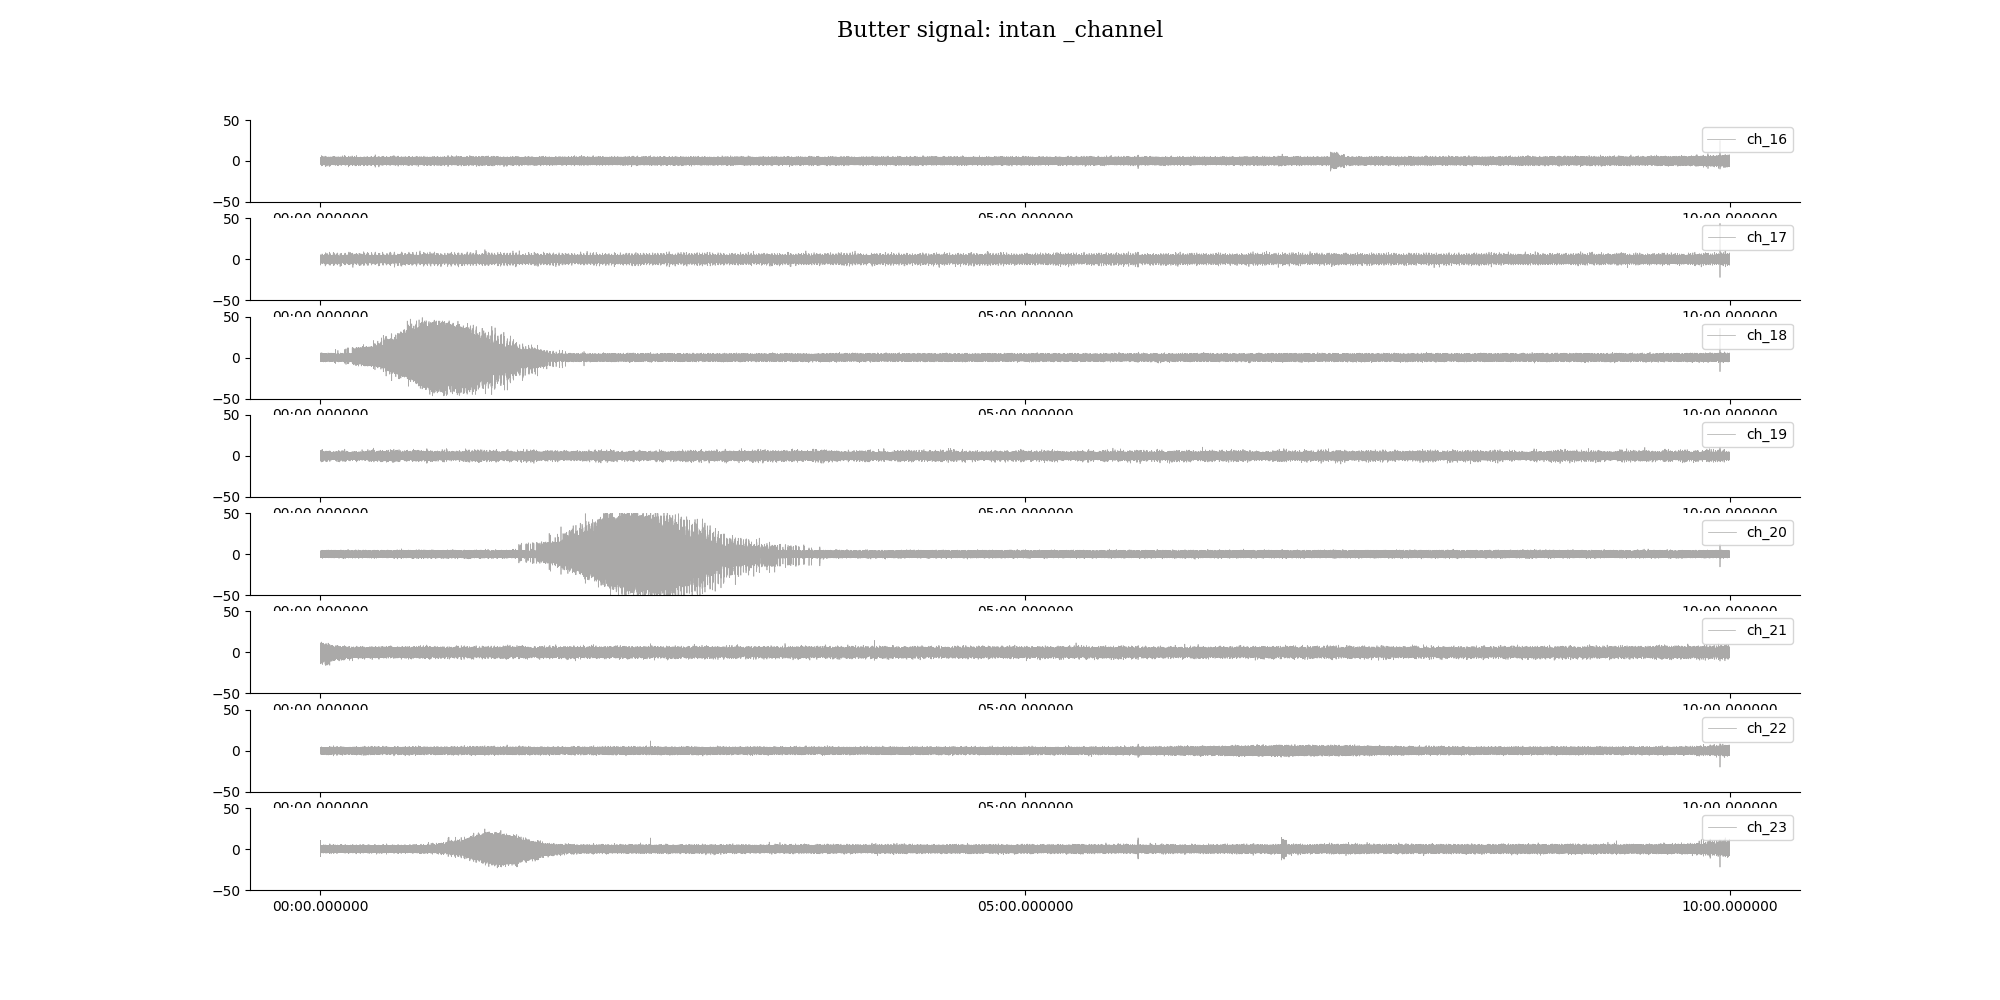

In [19]:
record.plot_signal(references_df.loc[references_df.index[int((start_minute-start_minute)*60*record.fs)]:references_df.index[int((start_minute-start_minute)*60*record.fs)] + pd.Timedelta(seconds=(10*60))],
                       plot_ch,record.num_rows,record.num_columns, 
                       channels=record.channels, text_label='', text_title='Butter signal: intan _channel', ylim=[-50,50],
                       figsize=(20, 10), no_label=False, savefigpath='%s/figures/%s_%s_%s_seleced-%s-%s_%s.svg' %(record.path, port, window_ref, ref_ch_name, (start_minute), (end_minute), current_time),
                       show_plot=True)


###### Informative plot Velocity vs distance

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Parameters (✅ can be adjusted)
n_electrodes = 8
c2c = 4.5 # 2.52 #center to center from outer electrodes
spacing_mm = c2c/7               # center-to-center spacing between electrodes 0.36
electrode_width_mm = 0.136      # not currently used in v_min logic
fs = 20_000                     # Sampling frequency in Hz
dt = 1 / fs * 1000              # Sampling period in ms
max_delay_ms = 5              # Max allowable propagation delay (in ms)

# Compute distances and velocities
distances = []
v_max = []
v_min = []

for gap in range(1, n_electrodes):
    d = spacing_mm * gap  # center-to-center distance in mm
    vmax = d / dt  # max detectable velocity (shortest measurable delay)
    vmin = d / max_delay_ms  # min detectable velocity (longest meaningful delay)
    
    distances.append(d)
    v_max.append(vmax)
    v_min.append(vmin)

# Create table
table = pd.DataFrame({
    "Electrode Gap (# skipped)": np.arange(1, n_electrodes),
    "Distance (mm)": distances,
    "Max Detectable Velocity (m/s)": [round(v, 2) for v in v_max],
    "Min Detectable Velocity (m/s)": [round(v, 2) for v in v_min]
})

# Literature conduction velocity ranges
fiber_info = {
    "C fibers": (0.5, 2),
    "Aδ fibers": (5, 30),
    "Aβ fibers": (30, 70),
    "Aα fibers (motor)": (70, 120)
}

# Plotting
fig, axs = plt.subplots(3, 1, figsize=(10, 10), gridspec_kw={'height_ratios': [2, 2, 1]})
fig.suptitle("Detectable Neural Conduction Velocities by Electrode Configuration", fontsize=14)

# Subplot 1: Max velocity
axs[0].plot(distances, v_max, 'o-', color='blue', label="Max Detectable Velocity")
axs[0].set_ylabel("Velocity (m/s)")
axs[0].set_title("Max Detectable Velocity vs. Electrode Distance")
axs[0].grid(True)
axs[0].set_xticks(distances)
axs[0].legend()
axs[0].set_ylim(0, max(v_max) * 1.1)

# Subplot 2: Min velocity
axs[1].plot(distances, v_min, 'o-', color='orange', label="Min Detectable Velocity")
axs[1].set_title(f"Min Detectable Velocity (max delay = {max_delay_ms} ms)")
axs[1].set_xlabel("Inter-Electrode Distance (mm)")
axs[1].set_ylabel("Velocity (m/s)")
axs[1].grid(True)
axs[1].set_xticks(distances)
axs[1].legend()

# Subplot 3: Literature ranges
colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(fiber_info)))
for i, (fiber, (vmin_f, vmax_f)) in enumerate(fiber_info.items()):
    axs[2].barh(i, vmax_f - vmin_f, left=vmin_f, color=colors[i], edgecolor='k')
    axs[2].text(vmax_f + 1, i, f"{vmin_f}–{vmax_f} m/s", va='center', fontsize=9)

axs[2].set_yticks(range(len(fiber_info)))
axs[2].set_yticklabels(fiber_info.keys())
axs[2].set_xlabel("Conduction Velocity (m/s)")
axs[2].set_title("Literature Conduction Velocity Ranges")
axs[2].grid(True, axis='x', linestyle='--', alpha=0.6)
#axs[2].set_xlim(0, max(v_max) * 1.2)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Print table
print("\n🟢 Detectable Velocity Table:\n")
print(table.to_string(index=False))

print("\n📄 AP Conduction Velocities (Literature):\n")
for fiber, (vmin_f, vmax_f) in fiber_info.items():
    print(f"{fiber}: ~{vmin_f}–{vmax_f} m/s")


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
n_electrodes = 8
spacing_mm = c2c/7   # center-to-center spacing
gaps = np.arange(1, n_electrodes)  # 1 to n-1
distances_mm = spacing_mm * gaps

# Fiber conduction velocity ranges (in m/s)
fiber_info = {
    "C fibers": (0.5, 2),
    "Aδ fibers": (5, 30),
    "Aβ fibers": (30, 70),
    "Aα fibers (motor)": (70, 120)
}

# Compute delays = d / v  →  delays in ms
fig, axs = plt.subplots(len(fiber_info), 1, figsize=(8, 10), sharex=True)
fig.suptitle("Optimal Delay vs. Electrode Gap for Each Fiber Type", fontsize=14)

for ax, (fiber, (v_min, v_max)) in zip(axs, fiber_info.items()):
    # Generate velocities across the range (optional smooth curve)
    v_vals = np.linspace(v_min, v_max, 50)

    for v in [v_min, (v_min + v_max)/2, v_max]:
        delays_ms = distances_mm / v  # in ms
        ax.plot(distances_mm, delays_ms, marker='o', label=f'{v:.1f} m/s')

    ax.set_title(f"{fiber}")
    ax.set_ylabel("Delay (ms)")
    ax.grid(True)
    ax.legend(title="Velocity")

axs[-1].set_xlabel("Electrode distance")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


##### Bipolar

In [ ]:
import itertools
import pandas as pd

signal = selected_data  # Original signal

# Get the list of filtered channels
all_ch_list = [col for col in record.filter_ch if col.startswith('ch_')]

# Generate all possible bipolar channel pairs
bipolar_pairs = list(itertools.combinations(all_ch_list, 2))

# Create a DataFrame to store bipolar references
references_df = pd.DataFrame(index=signal.index)

# Compute bipolar references for each pair
for ch1, ch2 in bipolar_pairs:
    references_df[f"{ch1}-{ch2}"] = signal[ch1] - signal[ch2]

# Print the resulting DataFrame shape and column names
print(f"Bipolar references computed: {references_df.shape}")
print("Bipolar channels:", references_df.columns.tolist())
print(references_df.head())

In [ ]:
import matplotlib.pyplot as plt

# Define the time range to plot (in minutes)
start_minut_plote = 135-start_minute  # Example: Start at 10 minutes

# Filter the dataframe based on the time range
plot_df = references_df.loc[references_df.index[int(start_minut_plote*60*record.fs)]:references_df.index[int(start_minut_plote*60*record.fs)] + pd.Timedelta(seconds=(10*60))]

# Create figure with subplots (one for each bipolar pair)
fig, axes = plt.subplots(len(references_df.columns), 1, figsize=(12, len(references_df.columns) * 2), sharex=True, sharey=True)

# If there's only one pair, make axes a list for consistency
if len(plot_df.columns) == 1:
    axes = [axes]

# Loop through bipolar pairs and plot
for ax, col in zip(axes, plot_df.columns):
    print('Printing %s' %col)
    ax.plot(plot_df.index, plot_df[col], label=col, color='black', alpha=0.8)  # Convert x-axis to minutes
    ax.set_ylabel(col)
    ax.set_ylim([-50, 50])
    ax.legend(loc='upper right', fontsize=8)

# Formatting
axes[-1].set_xlabel("Time (min)")  # X-axis in minutes
fig.suptitle(f"Bipolar Referenced Signals ({start_minute}-{end_minute} min)", fontsize=14)

# Improve layout
plt.tight_layout()
plt.savefig(f'{record.path}/figures/{port}_{window_ref}_bipolar_{start_minute}-{end_minute}min_{current_time}.svg', dpi=300)

plt.show()


##### Tripolar recording

In [ ]:
import pandas as pd

# ---- Parameters ----
signal = selected_data  # Your original signal dataframe
channels = record.filter_ch  # Channel names or numbers
offset = 1  # Distance for referencing (e.g., 1 = immediate neighbor, 2 = skip one) - For E3-Port B use 1 cause only 3 channels

# ---- Tripolar Computation ----
tripolar_signals = {}
tripolar_labels = {}

for i in range(offset, len(channels) - offset):  # Avoid borders
    center = channels[i]
    proximal = channels[i - offset]
    distal = channels[i + offset]
    
    tripolar_name = f"Tripolar_{i}_offset{offset}"
    tripolar_signals[tripolar_name] = 2 * signal[center] - (signal[proximal] + signal[distal])
    tripolar_labels[tripolar_name] = f"2×{center} - ({proximal} + {distal})"

# ---- Convert to DataFrame ----
references_df = pd.DataFrame(tripolar_signals, index=signal.index)

# ---- (Optional) If you want to keep labels for later use ----
references_df.attrs["labels"] = tripolar_labels

print(f"Tripolar referencing computed with offset = {offset}")
print(tripolar_labels)


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Filter the dataframe based on the selected time range
st_plot_minute = start_min  # Starting minute
end_plot_minute = 10  # dur

# Filter the references dataframe for the selected time range
plot_df = references_df.loc[references_df.index[int(st_plot_minute * 60 * record.fs)]:references_df.index[int(st_plot_minute * 60 * record.fs)] + pd.Timedelta(seconds=(end_plot_minute * 60))]

# Get the number of tripolar signals available
num_tripolar_signals = len(tripolar_labels)

# If there's only one tripolar signal, plot it in a single subplot.
# Otherwise, plot each signal in its own subplot.
fig, axes = plt.subplots(num_tripolar_signals, 1, figsize=(12, max(5 * num_tripolar_signals, 10)), sharex=True, sharey=True)

# If there's only one signal, make `axes` a list for consistency
if num_tripolar_signals == 1:
    axes = [axes]  # Convert to list so the loop works for both cases

# Plot each tripolar signal
for ax, (col, label) in zip(axes, tripolar_labels.items()):
    ax.plot(plot_df.index, plot_df[col], label=label, color='black', alpha=0.8)
    ax.set_ylabel("Tripolar Signal (µV)")
    ax.set_ylim([-100, 100])  # Adjust depending on the signal amplitude
    ax.legend(loc="upper right")
    ax.set_xlabel("Time (min)")

# Set the overall figure title
fig.suptitle(f"Tripolar Referenced Signals from {start_minute} to {end_minute} Minutes")

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Leave space for the suptitle

# Save the figure
plt.savefig(f'{record.path}/figures/{port}_{window_ref}_tripolar_{start_minute}-{end_minute}min_{current_time}.svg', dpi=300)

# Show the plot
plt.show()


### Multiple channels analysis - after median

This section aims to find which channels are noisy, and whether propagation exists (vs control device)

#### Sike detection for all channels ->std=0.5 to capture all the spikes

In [ ]:
record.channels

Channel 16
Channel 17
Channel 18
Channel 19
Channel 20
Channel 21
Channel 22
Channel 23


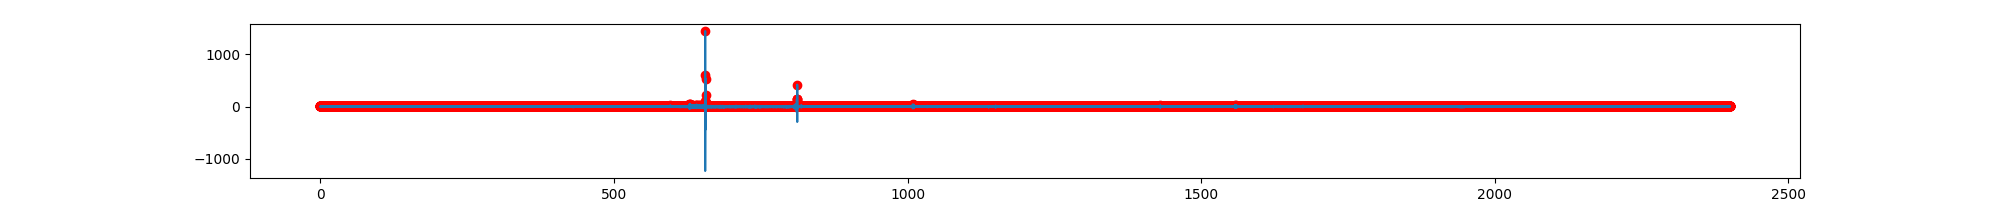

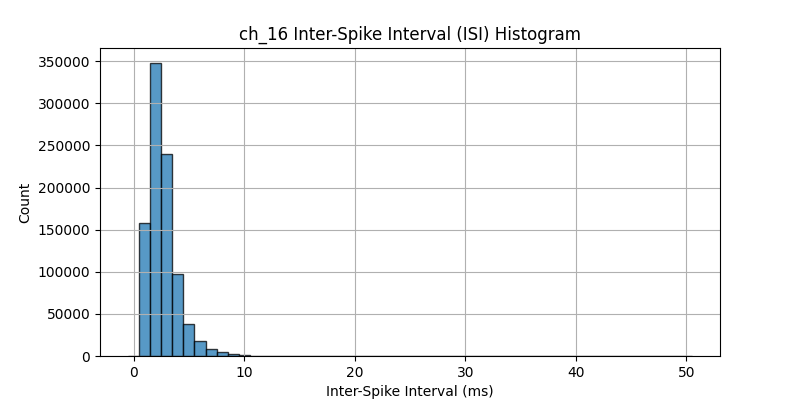

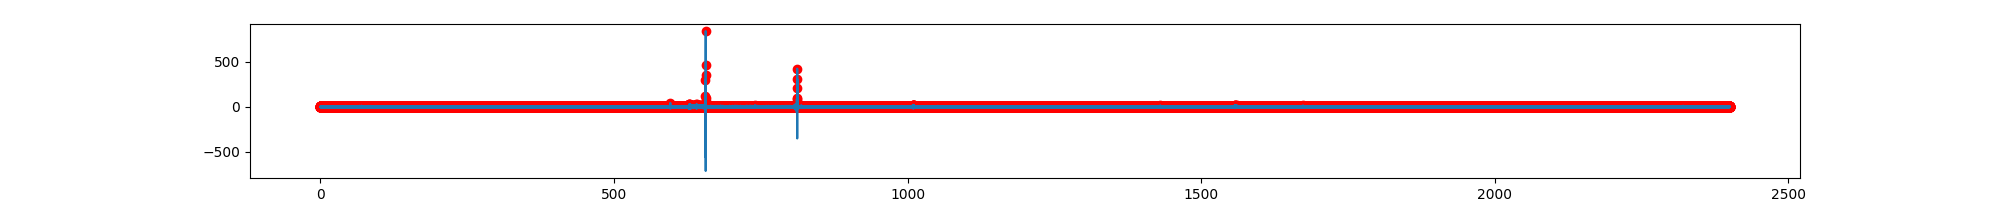

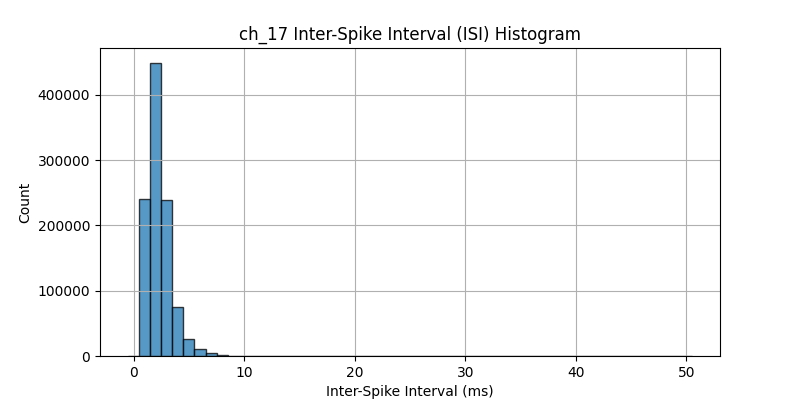

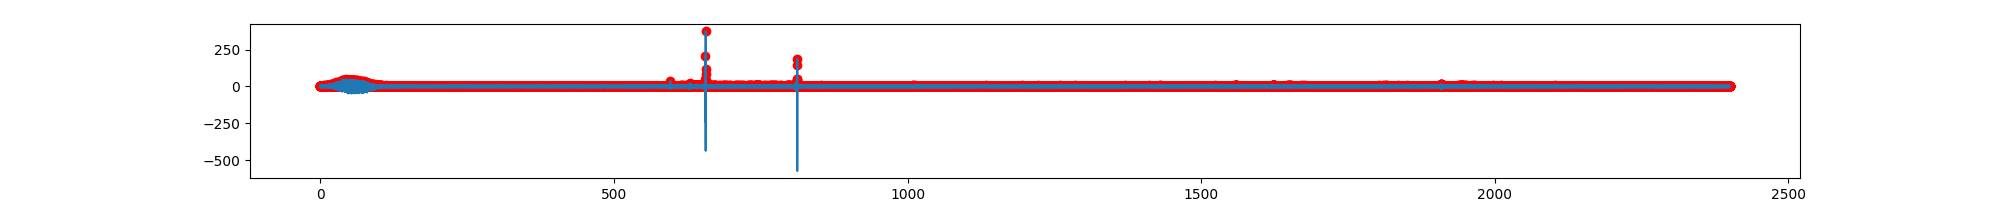

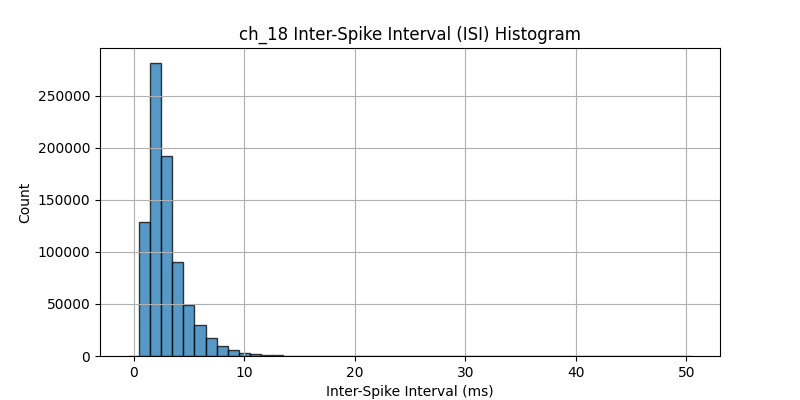

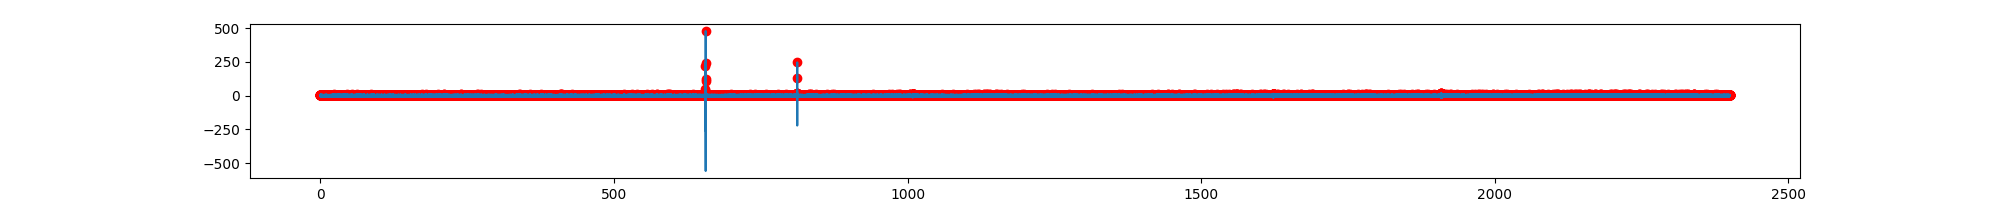

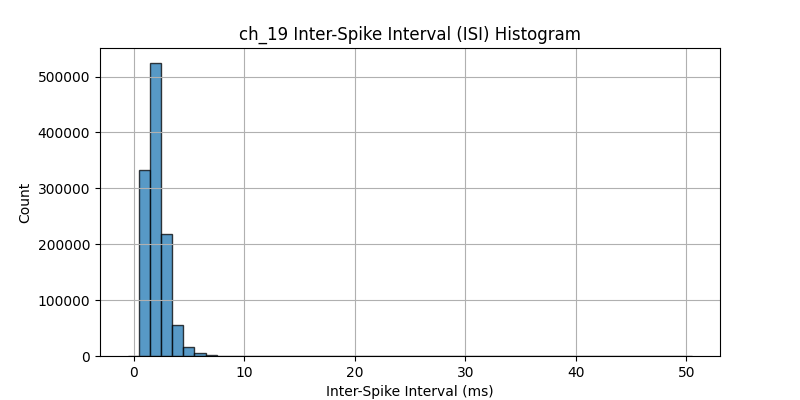

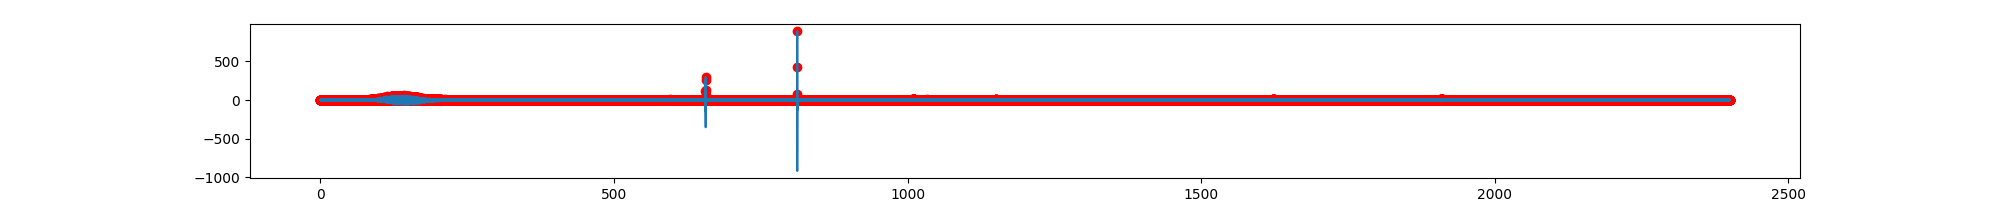

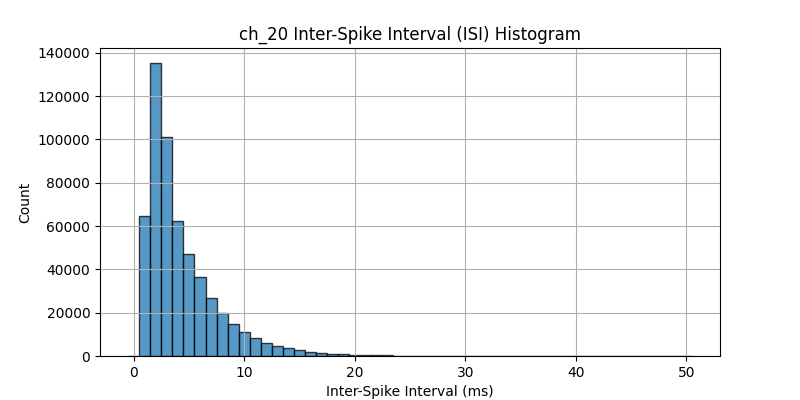

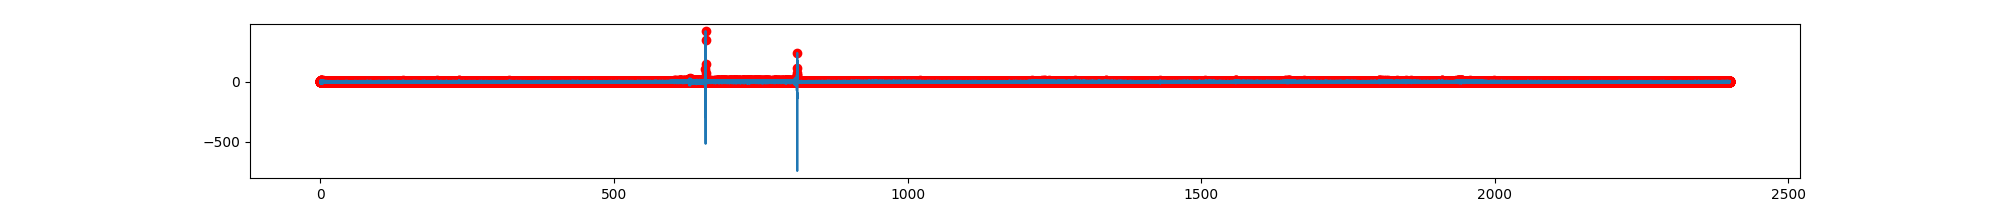

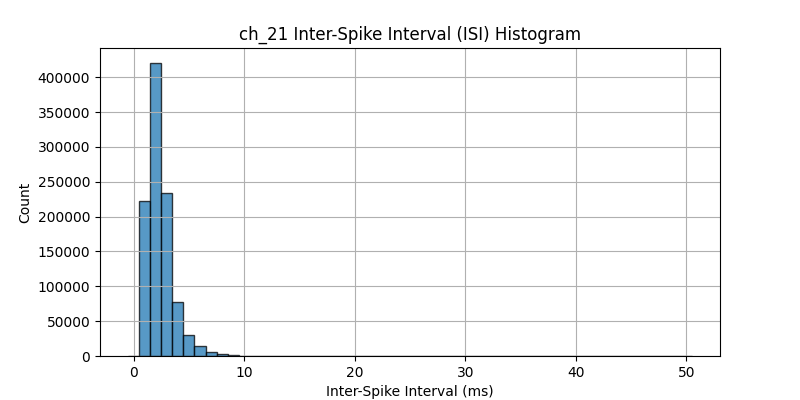

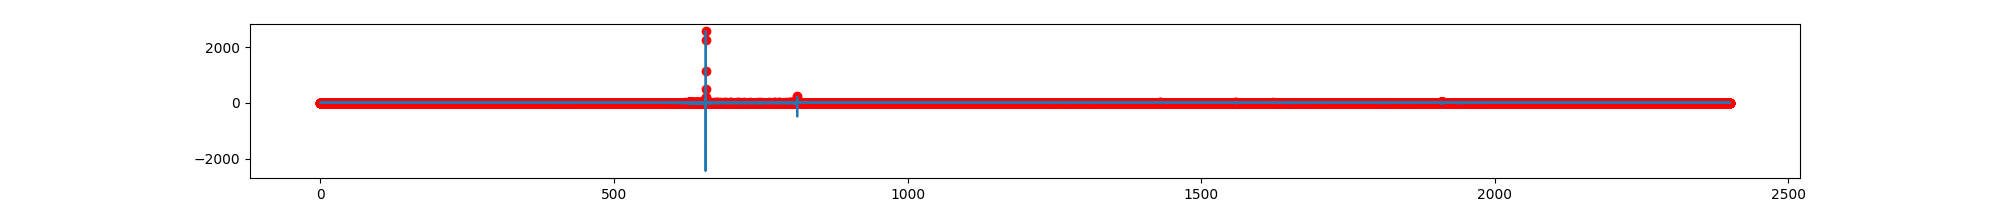

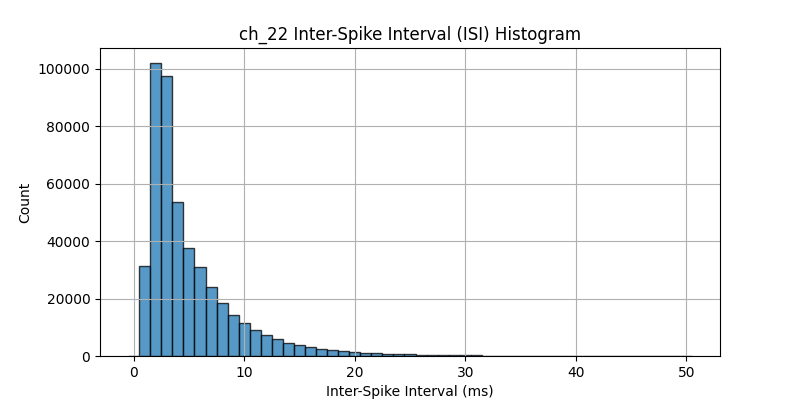

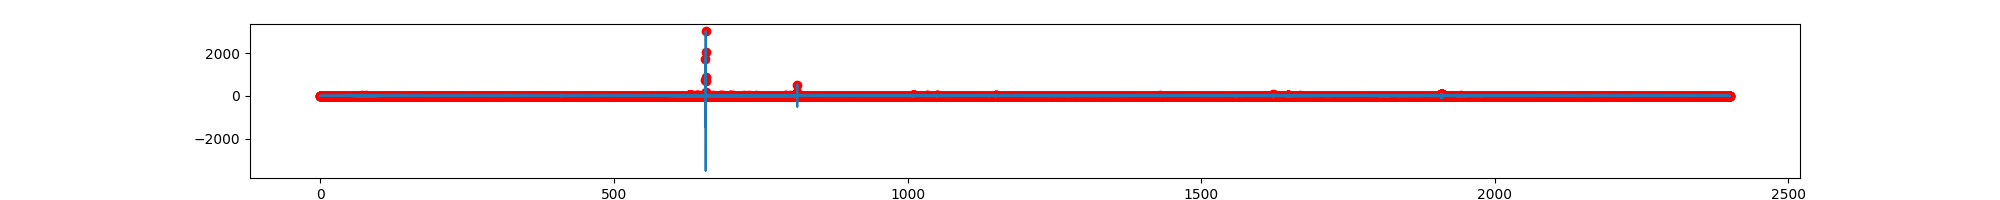

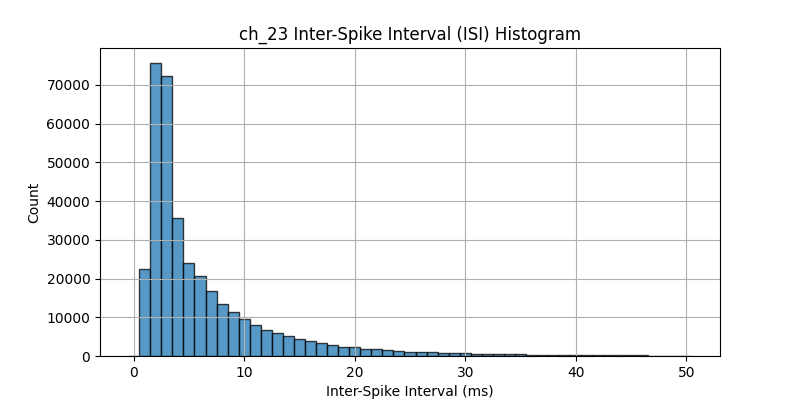

In [20]:
from scipy.signal import find_peaks

fs = record.fs
spike_trains = {}
spike_times_all={}

# All channels
for num, ch in enumerate(record.channels):
    print('Channel %s' %ch)
    # Select filtered signal to compute analysis
    filtered_signal = np.array(references_df['ch_%s'%ch].to_list())  # Make it accessible outside the function
    
    CAP_indices = []
    
    # 2. CAP Detection (Thresholding)
    def detect_CAPs(signal_data, low_threshold=1, up_threshold=5, min_distance=30): # 30 is 1.5ms at 20KHz was at 0.5std
        # Step 1: Standardize the signal
        z_signal = zscore(signal_data, nan_policy="omit")
        
        # Step 2: Find local maxima (peaks)
        peaks, _ = find_peaks(z_signal, height=low_threshold, distance=min_distance) #, up_threshold]
        # Step 2: Find local maxima (peaks)
        #peaks, _ = find_peaks(signal_data, height=[6], distance=min_distance)
        '''
        # Visual inspection of the standardized signal
        plt.figure(figsize=(10, 2))
        plt.plot(z_signal)
        plt.title("Z-scored signal")
        plt.show()

        # See how many peaks exist *before* thresholding
        all_peaks, _ = find_peaks(z_signal)
        print(f"Total peaks (no threshold): {len(all_peaks)}")
    
        # Now apply the actual detection with height
        peaks, properties = find_peaks(z_signal, height=(low_threshold, up_threshold), distance=min_distance)
        print(f"Filtered peaks (threshold + distance={min_distance}): {len(peaks)}")

        sys.exit()
        '''
        # Step 3: Return indices of detected peaks
        return peaks
    
    CAP_indices = detect_CAPs(filtered_signal, min_distance=int(1/1000*record.fs))  # 40 samples at 20KHz, 20 samples at 10KZ
    CAP_seconds = CAP_indices / record.fs
    # Append the detected spike times to `spike_trains`
    spike_trains[ch] = CAP_indices 

    plt.figure(figsize=(20, 2))
    # Plot the temporal signal on top of the heatmap
    time_vector = np.arange(len(filtered_signal)) / fs  # Time in seconds
    plt.plot(time_vector, filtered_signal)
    plt.scatter(CAP_indices/record.fs, filtered_signal[CAP_indices], color='red', label='CAPs')
    # Save the plot
    plt.savefig('%s/figures/%s_%s_ch%s_%s_%s_%s-%smin_%s.png' %(record.path, ref_ch_name, port,ch,window_ref, 'scatter',start_minute, end_minute, current_time), dpi=300)  # Save as PNG with high resolution
    #sys.exit()
    
    '''
    # Extract spike waveforms
    window_size = int(2*fs/1000)  # Number of samples before and after the spike for extracting waveforms
    spike_waveforms = []
    spike_indices = []
    
    for idx in CAP_indices:
        start = max(0, idx - window_size)
        end = min(len(filtered_signal), idx + window_size)
        # Extract waveform
        waveform = filtered_signal[start:end]
        
        # Pad waveform if it's shorter than the window size
        if len(waveform) < window_size * 2:
            # Pad the waveform with zeros on both sides
            pad_left = (window_size * 2 - len(waveform)) // 2
            pad_right = window_size * 2 - len(waveform) - pad_left
            waveform = np.pad(waveform, (pad_left, pad_right), mode='constant', constant_values=0)
            print('padding')
        spike_waveforms.append(waveform)
        spike_indices.append(idx)
    
    spike_waveforms = np.array(spike_waveforms)
        
    # Compute the average spike waveform
    average_spike_waveform = np.mean(np.array(spike_waveforms), axis=0)
    std_spike_waveform = np.std(spike_waveforms, axis=0)
    '''
    
    # Plot
    '''
    plt.figure(figsize=(6, 4))
    plt.plot(average_spike_waveform, label="Average Spike Waveform Ch_%s"%ch, color='b')
    plt.fill_between(range(len(average_spike_waveform)), 
                     average_spike_waveform - 3*std_spike_waveform, 
                     average_spike_waveform + 3*std_spike_waveform, 
                     color='b', alpha=0.3, label="±3 STD")
    '''
    '''
    #
    #---------------------------------------------------
    # Step 4: Spike Duration Calculation
    def compute_spike_duration(waveform):
        threshold_10 = 0.1 * np.max(waveform)
        threshold_90 = 0.9 * np.max(waveform)
        duration = np.sum(waveform > threshold_10) - np.sum(waveform > threshold_90)
        return duration
    
    # Calculate durations of spikes
    spike_durations = [compute_spike_duration(w) for w in spike_waveforms]
    print("Ch_%s Average Spike Duration (ms): "%ch, np.mean(spike_durations)/fs*1000)
    '''
    
    # General ISI
    import numpy as np
    import matplotlib.pyplot as plt
    
    # Assuming CAP_times contains detected spike times in seconds
    spike_times = np.array(CAP_seconds) * 1000  # Convert to milliseconds
    spike_times_all[ch] = spike_times
    
    # Compute Inter-Spike Intervals (ISIs)
    isi = np.diff(spike_times)  # Compute time differences between consecutive spikes
    
    # Define histogram bins with 1 ms resolution
    bin_width = 1  # 1 ms resolution
    bins = np.arange(0-bin_width/2, 50+bin_width, bin_width)
    
    # Plot ISI histogram
    plt.figure(figsize=(8, 4))
    plt.hist(isi, bins=bins, edgecolor='black', alpha=0.75)
    plt.xlabel('Inter-Spike Interval (ms)')
    plt.ylabel('Count')
    plt.title('ch_%s Inter-Spike Interval (ISI) Histogram'%ch)
    plt.grid(True)
    # Save the plot
    plt.savefig('%s/figures/%s_%s_ch%s_%s_%s_%s-%smin_%s.svg' %(record.path, ref_ch_name, port,ch,window_ref, 'ISI-hist',start_minute, end_minute, current_time), dpi=300)  # Save as PNG with high resolution
    
    #-----------------------------------------
    # Heatmaps ISI
    # Convert spike times to milliseconds
    spike_times = np.array(CAP_seconds) * 1000  
    
    # Define window size (10 seconds in milliseconds)
    window_size = 10 * 1000  
    isi_range = 20  # Maximum ISI to display
    
    # Find the maximum time to define the range
    max_time = spike_times[-1]  
    windows = np.arange(0, max_time, window_size)
    '''
    # Compute ISIs within each window
    isi_windows = []
    window_centers = []
    
    for start in windows:
        end = start + window_size
        mask = (spike_times >= start) & (spike_times < end)
        spikes_in_window = spike_times[mask]
        
        if len(spikes_in_window) > 1:
            isi = np.diff(spikes_in_window)
            isi_windows.append(isi)
            window_centers.append(start + window_size / 2)
    
    # Convert to a 2D array for visualization
    isi_matrix = np.zeros((len(isi_windows), isi_range))  # 20 ms ISI range
    
    for i, isi in enumerate(isi_windows):
        hist, bin_edges = np.histogram(isi, bins=np.arange(0, isi_range + 1, 1))
        isi_matrix[i, :] = hist
    
    # Adjust the color range (Set vmin and vmax for better contrast)
    color_min, color_max = 1, np.max(isi_matrix)  # Adjust these as needed
      
    # Create a figure with heatmap and temporal signals overlaid
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Plot the ISI heatmap
    vmin = np.min(isi_matrix[isi_matrix > 0]) if np.any(isi_matrix > 0) else 0
    vmax = np.max(isi_matrix) if np.any(isi_matrix > 0) else 1
    
    im = ax.imshow(isi_matrix.T, aspect='auto', cmap='hot', origin='lower',
                   extent=[window_centers[0] / 1000, window_centers[-1] / 1000, 0, isi_range],  # Ensure in seconds
                   vmin=vmin, vmax=vmax)
    
    # Set the color limits on the image, NOT the colorbar
    vmin = im.get_array().min()
    vmax = im.get_array().max() * 0.3
    im.set_clim(vmin, vmax)  # Apply the color limit to the heatmap
    
    # Now create the colorbar
    cbar = plt.colorbar(im, ax=ax)

    cbar.set_label('ISI Count')
    
    # Plot the temporal signal on top of the heatmap
    time_vector = np.arange(len(filtered_signal)) / fs  # Time in seconds
    
    # Scale the signal to fit within the plot
    # Scale the signal to be centered around 10 with a range of 10 (from 5 to 15)
    scaled_signal = 10 + (filtered_signal - np.min(filtered_signal)) / (np.max(filtered_signal) - np.min(filtered_signal)) * 10
    ax.scatter(CAP_indices/record.fs, scaled_signal[CAP_indices], color='red', label='CAPs')

    # Plot the temporal signal
    ax.plot(time_vector, scaled_signal, label="Channel %s" % ch, color="b", linewidth=2)
    
    # Adjust the x-axis to cover the range of both the heatmap and the signal
    time_start = window_centers[0] / 1000  # Convert to seconds
    time_end = window_centers[-1] / 1000   # Convert to seconds
    
    # Set the xlim based on the full range of the data
    ax.set_xlim([time_start, time_end])
    
    # Add labels and title
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('ISI (ms)')
    ax.set_title('ISI Distribution Over Time with Temporal Signals')
    
    # Add legend
    ax.legend(loc='upper right')
    plt.savefig('%s/figures/%s_%s_ch%s_%s_%s_%s-%smin_%s.svg' %(record.path,ref_ch_name, port,ch,window_ref, 'ISI-time',(start_minute), (end_minute), current_time), dpi=300)  # Save as PNG with high resolution
    #plt.show()
    '''

#### Cross-correlation of spike trains detected from each channel
Good to check localisation of signals and channel similarity

This code analyzes the spatial correlation of neural activity recorded across multiple electrodes by computing cross-correlations between spike trains and plotting the relationship between correlation strength and inter-electrode distance.
- Whether closely spaced electrodes exhibit higher spike train correlation.
- Whether farther apart electrodes show weaker correlations.

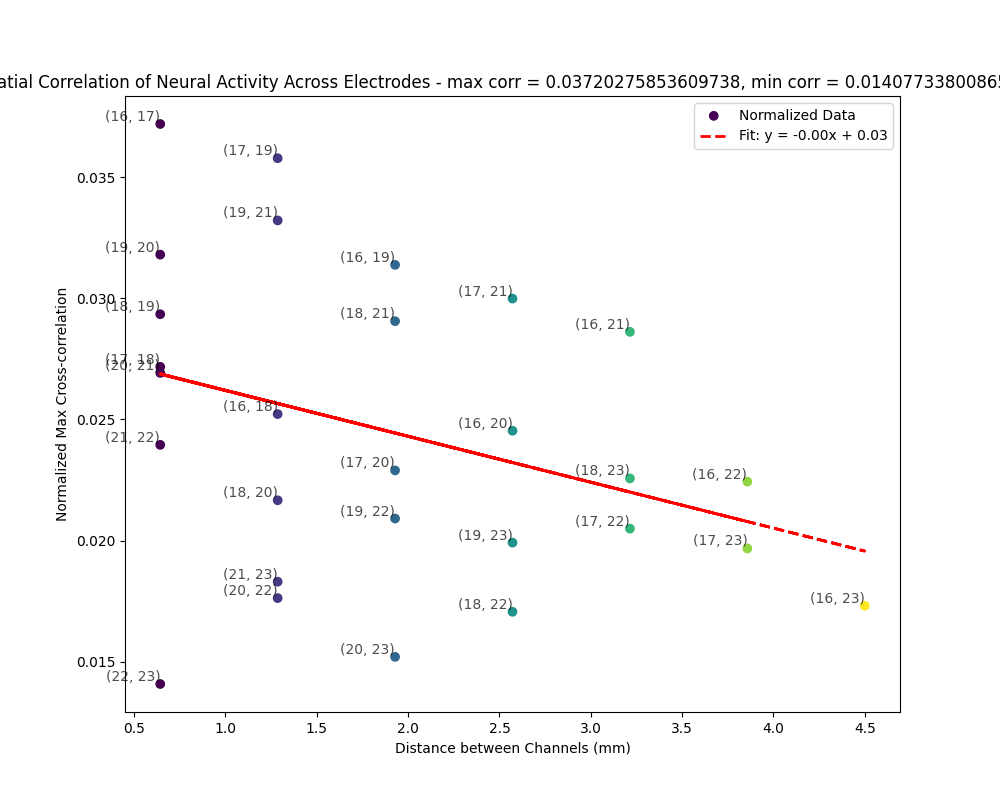

Saved correlation values to: C:/Users/ampar/Ag2239 Dropbox/Amparo Güemes/Datasets/recording/Cambridge/Epilepsy - pilot/Epilepsy-R11-SD-4.5mm-control/rec_250617_134113/figures/median_Port B_ch23_whole_cross-corr-spikes_0-40min_27062025_115611_corr.csv


In [21]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import correlate
c2c = 4.5

# Define the actual recorded channels and the intended correct order
wrong_order = record.channels  # Available channels
#correct_order = [13, 12, 19, 20, 21, 22, 11, 10]  # Full intended order
#correct_order = [24, 25, 5, 4, 3, 26, 18, 17]  # Full intended order - inverse connection

# For epilepsy (green PCB with the ZIF, inverse connection, otherwise 0-15)
#correct_order = [24, 25, 26,27,28,29,30,31] 
correct_order = [16,17,18,19,20,21,22,23] # E9 onwards 
#correct_order = [17, 18, 19, 20, 21, 22, 23, 24] #Only E1

# Find the available channels in the correct order
available_channels = [ch for ch in correct_order if ch in wrong_order]
channel_indices = {ch: i for i, ch in enumerate(correct_order)}  # Map channel to position
missing_channels = [ch for ch in correct_order if ch not in wrong_order]
if missing_channels:
    print("Missing channels:", missing_channels)
    
# Reorder the spike_trains dictionary based on available_channels and their spike times
channel_spike_times = [spike_trains[ch] for ch in available_channels]

# Electrode spacing
electrode_spacing = c2c/7 #0.36  # mm

# Compute distances, correlations, and labels
distances = []
correlation_values = []
color_labels = []
channel_pairs = []

num_channels = len(available_channels)

for i in range(num_channels):
    for j in range(i + 1, num_channels):
        ch1, ch2 = available_channels[i], available_channels[j]

        # Compute inter-electrode distance using their real positions
        dist = abs(channel_indices[ch1] - channel_indices[ch2]) * electrode_spacing
        distances.append(dist)

        # Compute cross-correlation
        spike_train_1 = np.histogram(channel_spike_times[i], bins=np.arange(0, max_time, 1))[0]
        spike_train_2 = np.histogram(channel_spike_times[j], bins=np.arange(0, max_time, 1))[0]
        #max_corr = np.max(correlate(spike_train_1, spike_train_2, mode='full'))

        # Cross-correlation
        cross_corr = correlate(spike_train_1, spike_train_2, mode='full')

        # Standardization using vector norms
        #This is similar to cosine similarity: the max of the cross-correlation is scaled relative to spike rate.
        norm_factor = np.sqrt(np.sum(spike_train_1**2) * np.sum(spike_train_2**2))
        standardized_max_corr = np.max(cross_corr) / norm_factor if norm_factor > 0 else 0

        correlation_values.append(standardized_max_corr)
        color_labels.append(abs(channel_indices[ch1] - channel_indices[ch2]) - 1)
        channel_pairs.append(f"({ch1}, {ch2})")

# Convert to numpy arrays
distances = np.array(distances)
correlation_values = np.array(correlation_values)
max_corr = np.max(correlation_values) 
min_corr = np.min(correlation_values) 

# Normalize correlation values between 0 and 1
#correlation_values = (correlation_values - np.min(correlation_values)) / (np.max(correlation_values) - np.min(correlation_values))

# Fit a linear model
slope, intercept = np.polyfit(distances, correlation_values, 1)
fit_line = slope * distances + intercept

# Plot correlation vs. distance with normalization
plt.figure(figsize=(10, 8))
scatter = plt.scatter(distances, correlation_values, c=color_labels, cmap='viridis', label="Normalized Data")
plt.plot(distances, fit_line, color='red', linestyle='--', linewidth=2, label=f"Fit: y = {slope:.2f}x + {intercept:.2f}")

# Annotate each point with its channel pair
for i, txt in enumerate(channel_pairs):
    plt.text(distances[i], correlation_values[i], txt, fontsize=10, ha='right', va='bottom', alpha=0.7)

plt.xlabel('Distance between Channels (mm)')
plt.ylabel('Normalized Max Cross-correlation')
plt.title('Spatial Correlation of Neural Activity Across Electrodes - max corr = %s, min corr = %s' %(max_corr, min_corr))

plt.legend()
plt.savefig('%s/figures/%s_%s_ch%s_%s_%s_%s-%smin_%s.svg' %(record.path,ref_ch_name, port,ch,window_ref, 'cross-corr-spikes',(start_minute), (end_minute), current_time), dpi=300)  # Save as PNG with high resolution
plt.show()


# Prepare the dataframe
corr_df = pd.DataFrame({
    'Channel Pair': channel_pairs,
    'Distance (mm)': distances,
    'Standardized Max Correlation': correlation_values,
})

# Save path
csv_corr_path = '%s/figures/%s_%s_ch%s_%s_%s_%s-%smin_%s_corr.csv' % (
    record.path, ref_ch_name, port, ch, window_ref, 'cross-corr-spikes', start_minute, end_minute, current_time
)

# Ensure the directory exists
os.makedirs(os.path.dirname(csv_corr_path), exist_ok=True)

# Save
corr_df.to_csv(csv_corr_path, index=False)
print(f"Saved correlation values to: {csv_corr_path}")

#### Directionality Analysis
Takes spike trains from multiple channels in a cuff electrode and analyzes directionality of propagation

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import itertools

# Electrode configuration
electrode_spacing = c2c/7 # 0.36  

#correct_order = [13, 12, 19, 20, 21, 22, 11, 10]  # Full intended order
#correct_order = [24, 25, 5, 4, 3, 26, 18, 17]  # Full intended order - inverse connection
print(correct_order)  # Taken from above to avoid mistakes

electrode_positions = {ch: i * electrode_spacing for i, ch in enumerate(correct_order)}
available_channels = [ch for ch in correct_order if ch in record.channels]
ordered_positions = {ch: electrode_positions[ch] for ch in available_channels}

# Compute distances between electrode pairs
electrode_distances = { (ch1, ch2): abs(ordered_positions[ch1] - ordered_positions[ch2]) 
                        for ch1, ch2 in itertools.combinations(available_channels, 2)}

# Function to compute delays and directionality
def compute_directionality_for_period(spike_times_all, ordered_positions, electrode_distances, max_delay=20):
    directionality_counts_window = {dist: {'positive': 0, 'negative': 0} for dist in set(electrode_distances.values())}
    delay_storage = {pair: [] for pair in electrode_distances}  # Store delays for later use

    for ch1, ch2 in itertools.combinations(ordered_positions.keys(), 2):
        print(ch1)
        print(ch2)
        print('--------')
        spikes_ch1 = spike_times_all.get(ch1, [])
        spikes_ch2 = np.array(spike_times_all.get(ch2, []))  # Convert to array once
        
        if len(spikes_ch1) == 0 or len(spikes_ch2) == 0:
            continue

        for spike1 in spikes_ch1:
            # Use boolean indexing for spikes_ch2 that are within the max_delay from spike1
            relevant_spikes_ch2 = spikes_ch2[(spikes_ch2 >= spike1 - max_delay) & (spikes_ch2 <= spike1 + max_delay)]
            spike_diff = relevant_spikes_ch2 - spike1  # Calculate the time difference

            delay_storage[(ch1, ch2)].extend(spike_diff)  # Store delays
            
            directionality = np.sign(spike_diff)
            distance = electrode_distances.get((ch1, ch2))
            
            if distance is None:
                continue  

            for direction in directionality:
                if direction == 1:
                    directionality_counts_window[distance]['positive'] += 1
                elif direction == -1:
                    directionality_counts_window[distance]['negative'] += 1

    return directionality_counts_window, delay_storage

# Function to process multiple periods
def split_and_compute_directionality(spike_times_all, ordered_positions, electrode_distances, num_periods, len_period, max_delay=20):
    if not spike_times_all or all(len(times) == 0 for times in spike_times_all.values()):
        raise ValueError("No spike times available to process.")
    
    period_length = len_period*60*1000  # Fixed milliseconds
    
    directionality_counts_all = []
    delay_storage_all = []

    for i in num_periods:
        start_time = i * period_length
        print(start_time) 
        end_time = (i + 1) * period_length

        spike_times_period = {ch: [spike for spike in spike_times_all.get(ch, []) if start_time <= spike < end_time]
                              for ch in spike_times_all}
        
        print(f"Window {i}: {start_time}-{end_time} millisec")
        
        directionality_counts_window, delay_storage_window = compute_directionality_for_period(
            spike_times_period, ordered_positions, electrode_distances,max_delay)
        
        directionality_counts_all.append(directionality_counts_window)
        delay_storage_all.append(delay_storage_window)

    return directionality_counts_all, delay_storage_all


max_delay = 7 # ms for max delay expected (more delay can introduce more noise and less differentiation in the plot of closer channels, lowe value means less slow fibers will propagate to reach the far electrodes
periods_min = [0] # min start of period
# Run the analysis and plot results
directionality_counts_all, delay_storage_all = split_and_compute_directionality(
    spike_times_all, ordered_positions, electrode_distances, num_periods=periods_min, len_period =1, max_delay=max_delay) # len_period: minuted for the period to analyse

#plot_directionality(directionality_counts_all, electrode_distances)
#plot_delay_distribution(delay_storage_all, electrode_distances)


[16, 17, 18, 19, 20, 21, 22, 23]
0
Window 0: 0-60000 millisec
16
17
--------
16
18
--------
16
19
--------
16
20
--------
16
21
--------
16
22
--------
16
23
--------
17
18
--------
17
19
--------
17
20
--------
17
21
--------
17
22
--------
17
23
--------
18
19
--------
18
20
--------
18
21
--------
18
22
--------
18
23
--------
19
20
--------
19
21
--------
19
22
--------
19
23
--------
20
21
--------
20
22
--------
20
23
--------
21
22
--------
21
23
--------
22
23
--------


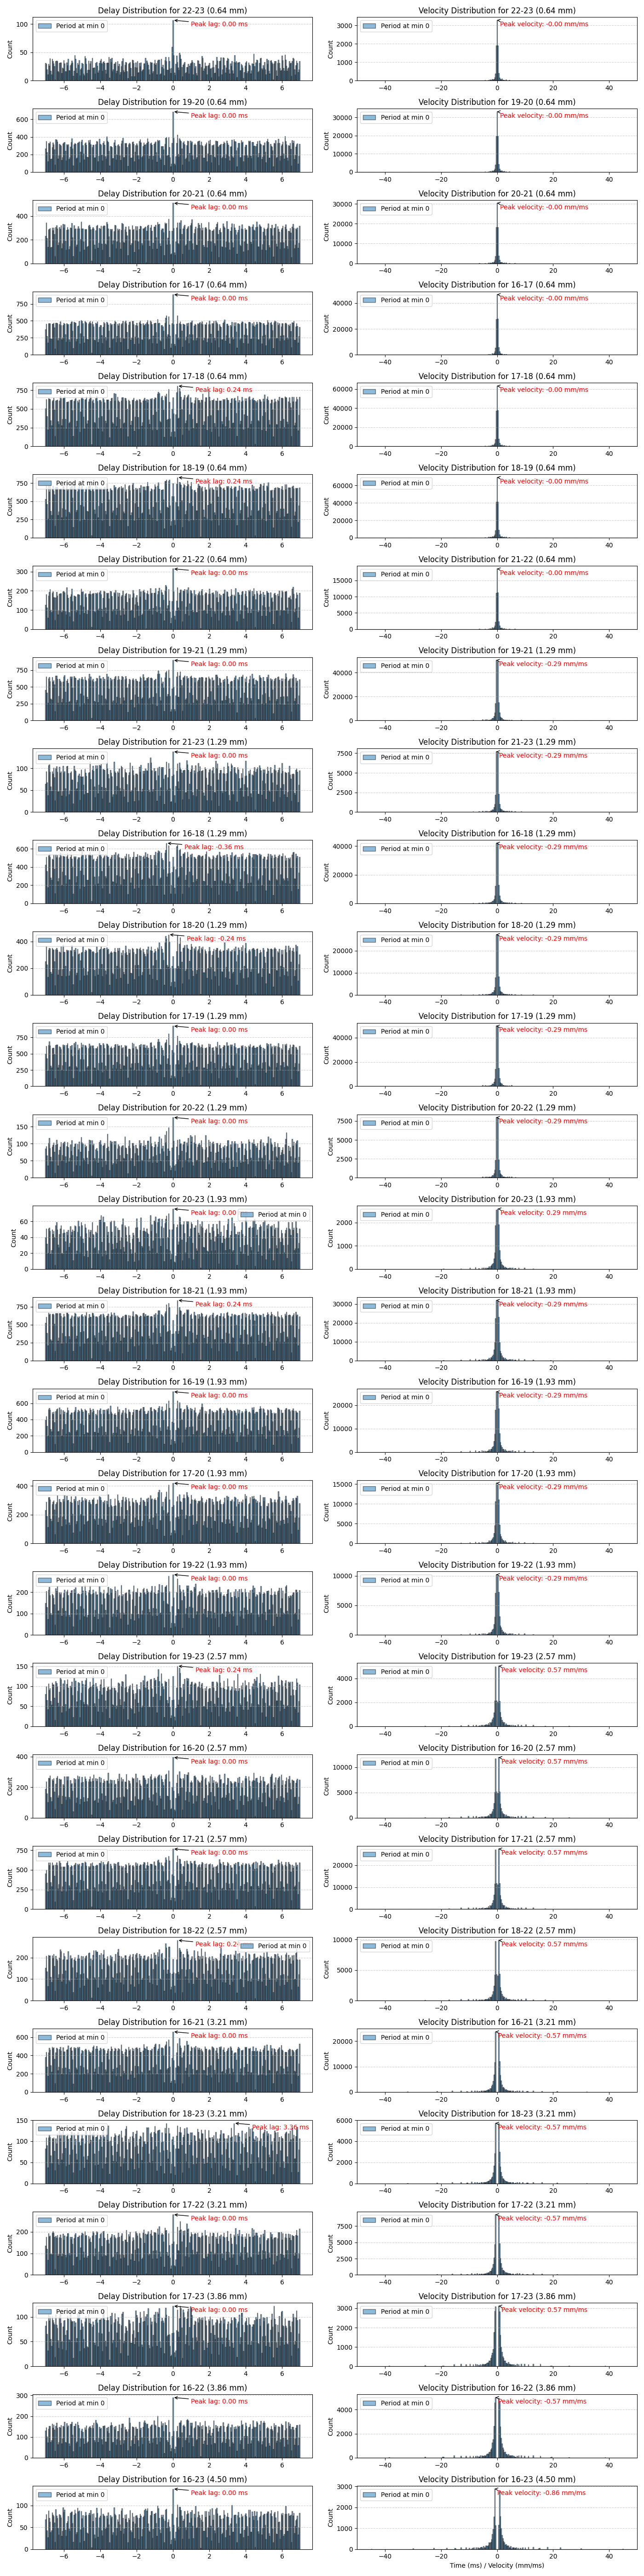

- In closer electrodes: response is almost instant, so most of the velocities are going to be Inf. That means that essentially anything more than 3ms delay will translate into the same <1mm/ms bin (~0).
- In far electrodes: to be able to differentiate velocities <0.2mm/ms, the delay has to be at least 12.5ms. So, the window to extract the values should be that. Otherwise, velocities will appear as 0 in the 0mm/ms bin.


In [23]:
import matplotlib.pyplot as plt
import numpy as np


def plot_delay_distribution(delay_storage_all, electrode_distances, periods_min,
                            max_delay=20, max_velocity=120, nbin=100, savepath =''):
    num_periods = len(delay_storage_all)
    min_delay_threshold = 0.1  # ms

    # === Define bin edges to center 0 ===
    delay_bin_width = (2 * max_delay) / nbin
    delay_edges = np.arange(-max_delay, max_delay + delay_bin_width, delay_bin_width)
    delay_edges -= delay_bin_width / 2
    delay_bin_centers = (delay_edges[:-1] + delay_edges[1:]) / 2

    velocity_bin_width = (2 * max_velocity) / nbin
    velocity_edges = np.arange(-max_velocity, max_velocity + velocity_bin_width, velocity_bin_width)
    velocity_edges -= velocity_bin_width / 2
    velocity_bin_centers = (velocity_edges[:-1] + velocity_edges[1:]) / 2

    sorted_pairs = sorted(electrode_distances.keys(), key=lambda pair: electrode_distances[pair])
    num_pairs = len(sorted_pairs)

    fig, axes = plt.subplots(nrows=num_pairs, ncols=2, figsize=(14, 2 * num_pairs))
    if num_pairs == 1:
        axes = [axes]

    for ax, (ch1, ch2) in zip(axes, sorted_pairs):
        delays_periods = [delay_storage_all[j].get((ch1, ch2), []) for j in range(num_periods)]

        if all(len(delays) == 0 for delays in delays_periods):
            ax[0].set_title(f"Pair {ch1}-{ch2} ({electrode_distances[(ch1, ch2)]:.2f} mm): No spikes detected")
            ax[1].set_title(f"Pair {ch1}-{ch2} ({electrode_distances[(ch1, ch2)]:.2f} mm): No spikes detected")
            continue

        # === Delay Histogram ===
        for j, delays in enumerate(delays_periods):
            ax[0].hist(delays, bins=delay_edges, alpha=0.5, edgecolor='black',
                       label=f"Period at min {periods_min[j]}")

        ax[0].set_ylabel("Count")
        ax[0].set_title(f"Delay Distribution for {ch1}-{ch2} ({electrode_distances[(ch1, ch2)]:.2f} mm)")
        ax[0].grid(axis='y', linestyle='--', alpha=0.6)
        ax[0].legend()

        # === Convert to velocities (v = d / t) ===
        velocities_periods = [
            [electrode_distances[(ch1, ch2)] / delay if abs(delay) > min_delay_threshold else np.nan
             for delay in delays]
            for delays in delays_periods
        ]
        all_velocities = [v for sublist in velocities_periods for v in sublist if not np.isnan(v)]

        for j, velocities in enumerate(velocities_periods):
            cleaned = [v for v in velocities if not np.isnan(v)]
            if cleaned:
                ax[1].hist(cleaned, bins=velocity_edges, alpha=0.5, edgecolor='black',
                           label=f"Period at min {periods_min[j]}")

        ax[1].set_xlim(-max_velocity, max_velocity)
        ax[1].set_ylabel("Count")
        ax[1].set_title(f"Velocity Distribution for {ch1}-{ch2} ({electrode_distances[(ch1, ch2)]:.2f} mm)")
        ax[1].grid(axis='y', linestyle='--', alpha=0.6)
        ax[1].legend()

        # === Annotate delay peak ===
        flat_delays = np.concatenate([np.array(d) for d in delays_periods if len(d) > 0])
        if len(flat_delays) > 0:
            delay_hist, _ = np.histogram(flat_delays, bins=delay_edges)
            if np.any(delay_hist):
                peak_delay = delay_bin_centers[np.argmax(delay_hist)]
                ax[0].annotate(f"Peak lag: {peak_delay:.2f} ms",
                               xy=(peak_delay, max(delay_hist)),
                               xytext=(peak_delay + 1, max(delay_hist) * 0.9),
                               arrowprops=dict(facecolor='black', arrowstyle='->'),
                               fontsize=10, color='red')

        # === Annotate velocity peak ===
        if len(all_velocities) > 0:
            velocity_hist, _ = np.histogram(all_velocities, bins=velocity_edges)
            if np.any(velocity_hist):
                peak_velocity = velocity_bin_centers[np.argmax(velocity_hist)]
                ax[1].annotate(f"Peak velocity: {peak_velocity:.2f} mm/ms",
                               xy=(peak_velocity, max(velocity_hist)),
                               xytext=(peak_velocity + 1, max(velocity_hist) * 0.9),
                               arrowprops=dict(facecolor='black', arrowstyle='->'),
                               fontsize=10, color='red')

    plt.xlabel("Time (ms) / Velocity (mm/ms)")
    plt.tight_layout()
    plt.savefig(savepath, dpi=300)  # Save as PNG with high resolution
    plt.show()

# Plot the results
plot_delay_distribution(delay_storage_all, electrode_distances,periods_min, max_delay=max_delay, max_velocity=50, nbin=int(max_delay / 0.02), savepath='%s/figures/%s_%s_ch%s_%s_%s_minwin%s_%s-%smin_%s.svg' %(record.path,ref_ch_name, port,ch,window_ref, 'propagation',periods_min[0], (start_minute), (end_minute), current_time)) # was at 200  350 bins in 7ms is 02 ms (or 0.1 ms depending on -7 to 7)
print('- In closer electrodes: response is almost instant, so most of the velocities are going to be Inf. '
      'That means that essentially anything more than 3ms delay will translate into the same <1mm/ms bin (~0).\n'
      '- In far electrodes: to be able to differentiate velocities <0.2mm/ms, the delay has to be at least 12.5ms. '
      'So, the window to extract the values should be that. Otherwise, velocities will appear as 0 in the 0mm/ms bin.')


In [ ]:
import numpy as np

def jitter_spike_train(spike_times, jitter_range_ms=10, fs=20000):
    """
    Randomly jitter spike times within a given range.
    
    Args:
        spike_times: original spike times (in ms)
        jitter_range_ms: amount of jitter (+/-) in ms
        fs: sampling frequency (Hz)
    
    Returns:
        jittered_spike_times: spike times after jittering
    """
    jitter_amount = np.random.uniform(-jitter_range_ms, jitter_range_ms, size=len(spike_times))
    jittered = np.clip(np.array(spike_times) + jitter_amount, 0, None)  # Ensure non-negative times
    return jittered
    
jitter_range_ms=0.1

jittered_spike_times_all = {
    ch: jitter_spike_train(spikes, jitter_range_ms=jitter_range_ms, fs=record.fs)  # or smaller range like 2ms
    for ch, spikes in spike_times_all.items()
}

print('Finished jitter')

directionality_counts_all_jitter, delay_storage_jittered = split_and_compute_directionality(
    jittered_spike_times_all, ordered_positions, electrode_distances, num_periods=periods_min, len_period =1, max_delay=max_delay) # len_period: minuted for the period to analyse


In [ ]:
# Plot the results
plot_delay_distribution(delay_storage_jittered, electrode_distances,periods_min, max_delay=max_delay, max_velocity=50, nbin=int(max_delay / 0.02), savepath='%s/figures/%s_%s_ch%s_%s_%s__%s_minwin%s_%s-%smin_%s.svg' %(record.path,ref_ch_name, port,ch,window_ref, 'jitter',jitter_range_ms, periods_min[0], (start_minute), (end_minute), current_time)) # was at 200  350 bins in 7ms is 02 ms (or 0.1 ms depending on -7 to 7)

#### Propagation index

In [ ]:
def compute_rolling_pi(spike_times_all, ordered_positions, electrode_distances, 
                       window_length_min=1, step_size_min=1, max_delay=7,
                       bin_range=(-7, 7), bin_width=0.1):
    """
    Compute Propagation Index (PI) across rolling windows.

    Args:
        spike_times_all: dict with {channel: spike_times (in ms)}.
        ordered_positions: dict mapping channel to position.
        electrode_distances: dict with pairwise distances.
        window_length_min: window length in minutes.  Each PI is calculated using 1 minutes of spike data.
        step_size_min: step size in minutes. How much the window moves each time
        max_delay: max propagation delay (ms).
        bin_range: range for histogram in ms.
        bin_width: histogram bin width in ms.

    Returns:
        periods_min: list of window start times (min).
        pi_dict: dict {pair: list of PI values over time}.
    """
    # Time parameters in milliseconds
    window_length_ms = window_length_min * 60 * 1000
    step_size_ms = step_size_min * 60 * 1000
    
    # Time range
    all_spikes = list(itertools.chain(*spike_times_all.values()))
    total_start = int(min(all_spikes))
    total_end = int(max(all_spikes))
    
    periods_min = []
    delay_storage_all = []

    for start in range(total_start, total_end - window_length_ms + 1, step_size_ms):
        print('Minute %s' %(start/60000))
        end = start + window_length_ms
        periods_min.append(start / 60000)  # for plotting in minutes

        # Filter spikes for this window
        spike_times_period = {
            ch: [spk for spk in spikes if start <= spk < end]
            for ch, spikes in spike_times_all.items()
        }

        # Compute delays
        _, delay_storage_window = compute_directionality_for_period(
            spike_times_period, ordered_positions, electrode_distances, max_delay=max_delay
        )
        delay_storage_all.append(delay_storage_window)

    # Now compute PI from collected delay data
    bins = np.arange(bin_range[0], bin_range[1] + bin_width, bin_width)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    zero_bin_idx = np.argmin(np.abs(bin_centers))

    all_pairs = set()
    for delays in delay_storage_all:
        all_pairs.update(delays.keys())
    
    pi_dict = {pair: [] for pair in all_pairs}

    for delays in delay_storage_all:
        for pair in all_pairs:
            pair_delays = delays.get(pair, [])
            if len(pair_delays) == 0:
                pi_dict[pair].append(np.nan)
                continue
            hist, _ = np.histogram(pair_delays, bins=bins)
            max_val = np.max(hist)
            val_at_0 = max(hist[zero_bin_idx - 1], max(hist[zero_bin_idx], hist[zero_bin_idx + 1]))
            pi = (max_val - val_at_0) / max_val if max_val > 0 else np.nan
            pi_dict[pair].append(pi)

    return periods_min, pi_dict




# Compute and plot Propagation Index
periods_min, pi_dict = compute_rolling_pi(
    spike_times_all, ordered_positions, electrode_distances, 
    window_length_min=1, step_size_min=1, max_delay=2,
    bin_range=(-2, 2), bin_width=0.002
)


Minute 0.0
16
17
--------
16
18
--------
16
19
--------
16
20
--------
16
21
--------
16
22
--------
16
23
--------
17
18
--------
17
19
--------
17
20
--------
17
21
--------
17
22
--------
17
23
--------
18
19
--------
18
20
--------
18
21
--------
18
22
--------
18
23
--------
19
20
--------
19
21
--------
19
22
--------
19
23
--------
20
21
--------
20
22
--------
20
23
--------
21
22
--------
21
23
--------
22
23
--------
Minute 1.0
16
17
--------
16
18
--------
16
19
--------
16
20
--------
16
21
--------
16
22
--------
16
23
--------
17
18
--------
17
19
--------
17
20
--------
17
21
--------
17
22
--------
17
23
--------
18
19
--------
18
20
--------
18
21
--------
18
22
--------
18
23
--------
19
20
--------
19
21
--------
19
22
--------
19
23
--------
20
21
--------
20
22
--------
20
23
--------
21
22
--------
21
23
--------
22
23
--------
Minute 2.0
16
17
--------
16
18
--------
16
19
--------
16
20
--------
16
21
--------
16
22
--------
16
23
--------
17
18
--------
17
19
-

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plot_rolling_pi(pi_dict, periods_min, electrode_positions, selected_pairs=None, save_path=None):
    plt.figure(figsize=(10, 6))
    pairs_to_plot = selected_pairs if selected_pairs else pi_dict.keys()

    # Sort channels by position
    channel_indices = {ch: i for i, ch in enumerate(sorted(electrode_positions, key=lambda x: electrode_positions[x]))}

    # Group pairs by spacing
    grouped_pairs = {i: [] for i in range(1, 8)}
    for pair in pairs_to_plot:
        if pair not in pi_dict or pair[0] not in channel_indices or pair[1] not in channel_indices:
            continue
        distance = abs(channel_indices[pair[0]] - channel_indices[pair[1]])
        distance = min(distance, 7)
        grouped_pairs[distance].append(pair)

    # Manually defined color and marker for each group
    cmap_groups = {
        1: ('#A9A9A9', '.'),       # Grey
        2: ('#a6cee3', ','),       # Light Blue
        3: ('#1f78b4', 'x'),       # Blue
        4: ('#33a02c', '^'),       # Green
        5: ('#ff7f00', 's'),       # Orange
        6: ('#e31a1c', 'D'),       # Red
        7: ('#6a3d9a', 'X')        # Purple
    }

    # Plot each group
    for spacing, pairs in grouped_pairs.items():
        color, marker = cmap_groups[spacing]
        for pair in pairs:
            plt.plot(periods_min, pi_dict[pair], label=f"{pair[0]}–{pair[1]} (d={spacing})",
                     marker=marker, color=color, markersize=6, linewidth=1.5)

    # Threshold lines
    plt.axhline(1, linestyle='--', color='green', alpha=0.3, label='PI = 1 (propagation)')
    plt.axhline(0, linestyle='--', color='red', alpha=0.3, label='PI = 0 (artifact)')

    plt.xlabel('Start Time (min)')
    plt.ylabel('Propagation Index (PI)')
    plt.title('Rolling Propagation Index (PI)')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    plt.tight_layout()

    # Save figure if path is given
    if save_path:
        plt.savefig(save_path, dpi=300)

        # Save CSV of PI values
        csv_path = save_path.replace('.svg', '_PI-values.csv')
        df_pi = pd.DataFrame(index=periods_min)
        for pair in pairs_to_plot:
            if pair in pi_dict:
                col_name = f"{pair[0]}–{pair[1]}"
                df_pi[col_name] = pi_dict[pair]
        df_pi.index.name = "Start Time (min)"
        df_pi.to_csv(csv_path)
        print(f"Saved PI values to: {csv_path}")

    plt.show()


    # Save CSV of PI values
    csv_path = save_path.replace('.svg', '_PI-values.csv')
    # Convert to dataframe
    df_pi = pd.DataFrame(index=periods_min)
    for pair in pairs_to_plot:
        if pair in pi_dict:
            col_name = f"{pair[0]}–{pair[1]}"
            df_pi[col_name] = pi_dict[pair]
    df_pi.index.name = "Start Time (min)"
    df_pi.to_csv(csv_path)
    print(f"Saved PI values to: {csv_path}")


plot_rolling_pi(pi_dict, periods_min, ordered_positions, save_path = '%s/figures/%s_%s_%s_%s_%s-%smin_%s.svg' %(record.path,ref_ch_name, port,window_ref, 'PI', (start_minute), (end_minute), current_time))  



### Single channel/tripolar analysis

This section rund spike detection and clustering from the tripolar channels once we have discarded bad channels and confirmed propagation in the previous section

#### Spike detection, visualisation and ISI for single channel 

In [ ]:
references_df

selected_data

In [ ]:
# Remove filtered_signal if it exists
try:
    del filtered_signal
except NameError:
    pass  # If filtered_signal wasn't defined, do nothing

ch = references_df.columns[0] # R4: Port B=2, Port A=2
filtered_signal = np.array(references_df[ch].to_list())  # Make it accessible outside the function



In [ ]:
from scipy.signal import find_peaks

low_threshold = 1.5 #std

fs = record.fs
CAP_indices = []

# 2. CAP Detection (Thresholding)
def detect_CAPs(signal_data, low_threshold=0.5, up_threshold=2, min_distance=30): # 30 is 3ms
    # Step 1: Standardize the signal for propagation analysis
    #z_signal = zscore(signal_data, nan_policy="omit")
    #plt.figure()
    #plt.plot(z_signal)
    #sys.exit()
    
    # Step 2: Find local maxima (peaks)
    #peaks, _ = find_peaks(z_signal, height=[low_threshold], distance=min_distance) #, up_threshold]
    # Step 2: Find local maxima (peaks)
    peaks, _ = find_peaks(signal_data, height=[4, ], distance=min_distance)
    
    # Step 3: Return indices of detected peaks
    return peaks

CAP_indices = detect_CAPs(filtered_signal, low_threshold=low_threshold, min_distance=2/1000*record.fs)
CAP_seconds = CAP_indices / fs

print(len(CAP_indices))

#----------------------------------------------------------------
# Extract spike waveforms
window_size = int(2*fs/1000)  # Number of samples before and after the spike for extracting waveforms
spike_waveforms = []
print(spike_waveforms)
spike_indices = []

for idx in CAP_indices:
    start = max(0, idx - window_size)
    end = min(len(filtered_signal), idx + window_size)
    # Extract waveform
    waveform = filtered_signal[start:end]
    
    # Pad waveform if it's shorter than the window size
    if len(waveform) < window_size * 2:
        # Pad the waveform with zeros on both sides
        pad_left = (window_size * 2 - len(waveform)) // 2
        pad_right = window_size * 2 - len(waveform) - pad_left
        waveform = np.pad(waveform, (pad_left, pad_right), mode='constant', constant_values=0)
        print('padding')
    spike_waveforms.append(waveform)
    spike_indices.append(idx)
    
spike_waveforms = np.array(spike_waveforms)

'''
# Plot a few waveforms
plt.figure(figsize=(10, 6))
for i in range(5):  # Plot 5 random spike waveforms
    plt.plot(spike_waveforms[i], label=f"Spike {i+1}")
plt.title("Spike Waveforms")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.legend()
plt.show()
'''
# Compute the average spike waveform
average_spike_waveform = np.mean(np.array(spike_waveforms), axis=0)
std_spike_waveform = np.std(spike_waveforms, axis=0)

# Plot
plt.figure(figsize=(6, 4))
plt.plot(average_spike_waveform, label="Average Spike Waveform", color='b')
plt.fill_between(range(len(average_spike_waveform)), 
                 average_spike_waveform - 3*std_spike_waveform, 
                 average_spike_waveform + 3*std_spike_waveform, 
                 color='b', alpha=0.3, label="±3 STD")
#
#---------------------------------------------------
# Step 4: Spike Duration Calculation
def compute_spike_duration(waveform):
    threshold_10 = 0.1 * np.max(waveform)
    threshold_90 = 0.9 * np.max(waveform)
    duration = np.sum(waveform > threshold_10) - np.sum(waveform > threshold_90)
    return duration

# Calculate durations of spikes
spike_durations = [compute_spike_duration(w) for w in spike_waveforms]
print("Average Spike Duration (ms): ", np.mean(spike_durations)/fs*1000)

#-----------------------------------------------------------------
# General ISI
import numpy as np
import matplotlib.pyplot as plt

# Assuming CAP_times contains detected spike times in seconds
spike_times = np.array(CAP_seconds) * 1000  # Convert to milliseconds

# Compute Inter-Spike Intervals (ISIs)
isi = np.diff(spike_times)  # Compute time differences between consecutive spikes

# Define histogram bins with 1 ms resolution
bin_width = 1  # 1 ms resolution
bins = np.arange(0-bin_width/2, 50+bin_width, bin_width)

# Plot ISI histogram
plt.figure(figsize=(10, 6))
plt.hist(isi, bins=bins, edgecolor='black', alpha=0.75)
plt.xlabel('Inter-Spike Interval (ms)')
plt.ylabel('Count')
plt.title('Inter-Spike Interval (ISI) Histogram - std:%s, %s-%smin' %(low_threshold, start_minute, end_minute))
plt.grid(True)
plt.savefig('%s/figures/%s_ch%s_%s_%s_%s-%smin_%s.svg' %(record.path, port,ch,window_ref, 'ISI',(start_minute), (end_minute), current_time), dpi=300)  # Save as PNG with high resolution

plt.show()
print(np.min(filtered_signal[CAP_indices]))

###### Plot all signals with identified spikes and superimposed waveforms


###### Visualization of overall firing rate with fit + spikes in circle

In [ ]:
# --- Visualization of overall firing rate with fit + spikes in circles---

import plotly.express as px
from scipy.signal import welch

fig, axs = plt.subplots(3, 1, figsize=(20, 10))

time_data = selected_data.index

# CAPs Detected

axs[0].plot(np.arange(0, len(filtered_signal)) / record.fs,filtered_signal)
axs[0].scatter(CAP_indices/record.fs, filtered_signal[CAP_indices], color='red', label='CAPs')
axs[0].set_title("Detected CAPs")
axs[0].set_ylim([-100,100])
axs[0].legend()

# Instantaneous Firing Rate
bin_size = 10 #sec
bins = np.arange(0, len(time_data)/fs, bin_size)
firing_rate, _ = np.histogram(CAP_seconds, bins=bins)
bin_centers = bins[:-1] + bin_size / 2

# Compute the linear fit
slope, intercept = np.polyfit(bin_centers, firing_rate, 1)  # Linear fit (degree=1)
fitted_line = np.poly1d((slope, intercept))  # Create linear equation

# Plot the firing rate
axs[1].plot(bin_centers, firing_rate, label='Firing Rate (Hz)')
axs[1].plot(bin_centers, fitted_line(bin_centers), '--r', label=f'Linear Fit (Slope={slope:.2f})')  # Add linear fit
axs[1].set_title("Instantaneous Firing Rate - std:%s, %s-%smin" %(low_threshold, start_minute, end_minute))
axs[1].legend()
axs[1].set_xlabel('Time (sec)')

'''
# 3. Power Spectral Density (PSD)
f_data, Pxx_den_data = signal.welch(filtered_signal, fs, nperseg=512) # nperseg
axs[2].semilogx(f_data, Pxx_den_data)
axs[2].set_xlabel('Frequency [Hz]')
axs[2].set_ylabel('PSD [V**2/Hz]')
'''
plt.tight_layout()
plt.savefig('%s/figures/%s_ch%s_%s_%s_%s-%smin_%s.svg' %(record.path, port,ch,window_ref, 'spikes',(start_minute), (end_minute), current_time), dpi=300)  # Save as PNG with high resolution

plt.show()
'''
# Interactive Plot (CAP Rate Over Time)
time_bins = np.linspace(0, len(time_data)/record.fs, 50)
CAP_hist, _ = np.histogram(CAP_seconds, bins=time_bins)
fig_interactive = px.line(x=time_bins[:-1], y=CAP_hist, labels={'x': 'Time (s)', 'y': 'CAP Rate'})
fig_interactive.show()
'''

##### ISI over time

In [ ]:
# ISI over time for selected channel

import numpy as np
import matplotlib.pyplot as plt

# Convert spike times to milliseconds
spike_times = np.array(CAP_seconds) * 1000  

# Define window size (10 seconds in milliseconds)
window_period = 10 * 1000  
isi_range = 20  # Maximum ISI to display

# Find the maximum time to define the range
max_time = spike_times[-1]  
windows = np.arange(0, max_time, window_period)

# Compute ISIs within each window
isi_windows = []
window_centers = []

for start in windows:
    end = start + window_period
    mask = (spike_times >= start) & (spike_times < end)
    spikes_in_window = spike_times[mask]
    
    if len(spikes_in_window) > 1:
        isi = np.diff(spikes_in_window)
        isi_windows.append(isi)
        window_centers.append(start + window_period / 2)

# Convert to a 2D array for visualization
isi_matrix = np.zeros((len(isi_windows), isi_range))  # 20 ms ISI range

for i, isi in enumerate(isi_windows):
    hist, bin_edges = np.histogram(isi, bins=np.arange(0, isi_range + 1, 1))
    isi_matrix[i, :] = hist

# Adjust the color range (Set vmin and vmax for better contrast)
color_min, color_max = 1, np.max(isi_matrix)  # Adjust these as needed

# Plot ISI heatmap
plt.figure(figsize=(10, 6))
im = plt.imshow(isi_matrix.T, aspect='auto', cmap='hot', origin='lower',
                extent=[window_centers[0] / 1000, window_centers[-1] / 1000, 0, isi_range],
                vmin=color_min, vmax=color_max)
cbar = plt.colorbar(im)
cbar.set_label('ISI Count')

# Adjust y-ticks to be centered
yticks = np.arange(0.5, isi_range, 1)  # Shift by 0.5 to center
plt.yticks(yticks, labels=np.arange(1, isi_range + 1, 1))

plt.xlabel('Time (s)')
plt.ylabel('ISI (ms)')
plt.title('ISI Distribution Over Time (%ss Windows, 1 ms resolution)'%window_period)
plt.show()


#### Clustering for selected channel

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import umap
import time
from concurrent.futures import ThreadPoolExecutor
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# Step 5: Classification of Neural vs. Noise using K-means Clustering (Based on waveform amplitude)

def dim_red_umap(waveforms, n_neighbors=15, n_components=3):
    print('enter')
    dataset_scaled = StandardScaler().fit_transform(waveforms)
    time_start = time.time()
    try:
        print('enter')
        reducer = umap.UMAP(random_state=42, n_neighbors=n_neighbors, n_components=n_components)
        umap_result = reducer.fit_transform(dataset_scaled)
    except TypeError:
        print("Reducing k...")
        try:
            reducer = umap.UMAP(random_state=42, n_neighbors=n_neighbors, n_components=n_components/2)
            umap_result = reducer.fit_transform(dataset_scaled)
        except TypeError:
            print('UMAP with n_components=3')
            try:
                reducer = umap.UMAP(random_state=42, n_neighbors=n_neighbors, n_components=3)
                umap_result = reducer.fit_transform(dataset_scaled)
            except TypeError:
                print('Cannot compute UMAP.')
                umap_result = []
    print('UMAP done! Time elapsed: {} seconds'.format(time.time() - time_start))
    return umap_result


def compute_power_features(waveform, fs=20000):
    # Simple FFT-based power calculation (much faster than Welch)
    n = len(waveform)
    fft_vals = np.abs(np.fft.fft(waveform))[:n // 2]
    freqs = np.fft.fftfreq(n, d=1/fs)[:n // 2]

    # Low and High frequency ranges
    low_freq_power = np.sum(fft_vals[freqs < 500])  #  
    high_freq_power = np.sum(fft_vals[freqs > 500])  # Artifacts signals stronger here

    return low_freq_power, high_freq_power

def extract_features_for_waveform(waveform):
    #mean_value = np.mean(waveform)  # Mean value of the waveform
    peak_to_peak = np.max(waveform) - np.min(waveform)  # Peak-to-Peak value (max - min)
    #duration = compute_spike_duration(waveform)  # Duration of the spike (calculate or estimate based on waveform)
    energy = np.sum(np.square(waveform))
    #low_freq_power, high_freq_power = compute_power_features(waveform)
    # End the timer for feature extraction

    return [peak_to_peak, energy]# low_freq_power, high_freq_power]

    
def classify_spikes_kmeans(spike_waveforms, n_clusters):
    t0 = time.time()
    
    print('enter')
    # Using ThreadPoolExecutor to parallelize feature extraction for faster processing
    with ThreadPoolExecutor() as executor:
        waveform_features = list(executor.map(extract_features_for_waveform, spike_waveforms))
    waveform_features = np.array(waveform_features)
    elapsed_time = time.time() - t0
    print(f"Feature extraction for waveform took {elapsed_time:.4f} seconds.")
    # Convert list of features into numpy array
    waveform_features = np.array(waveform_features)
    
    # KMeans clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(waveform_features)

    # End the timer for feature extraction
    elapsed_time = time.time() - t0
    print(f"Classifier took {elapsed_time:.4f} seconds.")

    # Compute metrics
    #sil_score = silhouette_score(waveform_features, kmeans.labels_)
    #db_index = davies_bouldin_score(waveform_features, kmeans.labels_)
    #ch_score = calinski_harabasz_score(waveform_features, kmeans.labels_)
    
    #print(f"Silhouette Score: {sil_score:.4f}")
    #print(f"Davies-Bouldin Index: {db_index:.4f}")
    #print(f"Calinski-Harabasz Score: {ch_score:.4f}")
    
    return kmeans.labels_, waveform_features
    
def classify_spikes_gmm(spike_waveforms, n_clusters): #supervised
    print('Processing waveforms...')
    waveform_features = []
    for waveform in spike_waveforms:
        mean_value = np.mean(waveform)  
        peak_to_peak = np.max(waveform) - np.min(waveform)  
        duration = compute_spike_duration(waveform)  
        energy = np.sum(np.square(waveform))
        waveform_features.append([peak_to_peak, duration, energy])  # Store these features
    
    waveform_features = np.array(waveform_features)

    # Normalize features
    waveform_features = StandardScaler().fit_transform(waveform_features)

    # GMM Clustering
    gmm = GaussianMixture(n_components=n_clusters, random_state=42)
    labels = gmm.fit_predict(waveform_features)

    return labels, waveform_features

import numpy as np
import hdbscan
from sklearn.preprocessing import StandardScaler

def classify_spikes_hdbscan(spike_waveforms):
    print('Processing waveforms...')
    
    # Compute waveform features: Mean, Peak-to-Peak, and Duration
    waveform_features = []
    for waveform in spike_waveforms:
        mean_value = np.mean(waveform)  
        peak_to_peak = np.max(waveform) - np.min(waveform)  
        duration = compute_spike_duration(waveform)  
        waveform_features.append([mean_value, peak_to_peak, duration])
    
    waveform_features = np.array(waveform_features)

    # Normalize the features
    waveform_features = StandardScaler().fit_transform(waveform_features)

    # Clustering using HDBSCAN
    clusterer = hdbscan.HDBSCAN(min_cluster_size=5)
    labels = clusterer.fit_predict(waveform_features)

    return labels, waveform_features
    
# Function to compute spike duration
def compute_spike_duration(waveform):
    # Simple estimate: time between first and last non-zero crossing
    non_zero_crossings = np.where(waveform != 0)[0]
    if len(non_zero_crossings) > 0:
        return non_zero_crossings[-1] - non_zero_crossings[0]
    else:
        return len(waveform)  # If no non-zero crossings, return full length


################################################################################################################
# Start

# Classify spikes into neural vs noise (based on waveform)
n_clusters = 2
labels, waveform_features = classify_spikes_kmeans(spike_waveforms, n_clusters=n_clusters)
#labels, waveform_features = classify_spikes_hdbscan(spike_waveforms)

# Create a color map for the clusters
colors = plt.cm.jet(np.linspace(0, 1, n_clusters))  # Using 'jet' colormap for n_clusters
# Find the global min and max across all clusters
global_min = np.min(spike_waveforms)
global_max = np.max(spike_waveforms)

# Create the figure with 2 columns (left: individual y-axis, right: global y-axis)
fig, axes = plt.subplots(n_clusters, 2, figsize=(5, n_clusters/2))

for i in range(n_clusters):
    cluster_waveforms = spike_waveforms[labels == i]
    mean_waveform = np.mean(cluster_waveforms, axis=0)
    
    # Left column (individual y-axis)
    axes[i, 0].plot(range(len(mean_waveform)), mean_waveform, color=colors[i])
    axes[i, 0].set_xlabel('Samples')
    axes[i, 0].set_ylabel(f'Cluster {i}')
    
    # Right column (common y-axis)
    axes[i, 1].plot(range(len(mean_waveform)), mean_waveform, color=colors[i])
    axes[i, 1].set_xlabel('Samples')
    axes[i, 1].set_ylabel(f'Cluster {i}')
    axes[i, 1].set_ylim(global_min, global_max)  # Apply global min/max for consistency

plt.tight_layout()
plt.savefig('%s/figures/%s_ch%s_%s_%s_%s-%smin_%s.svg' %(record.path, port,ch,window_ref, 'classified_waveforms',(start_minute), (end_minute), current_time), dpi=300)  # Save as PNG with high resolution

plt.show()

#--------------------------------------------------
# Function to compute ISI
# Create figure
fig, axes = plt.subplots(n_clusters, 1, figsize=(8, n_clusters/2), sharex=True)

# Assuming CAP_times contains detected spike times in seconds
spike_times = np.array(CAP_seconds) * 1000  # Convert to milliseconds

for i in range(n_clusters):
    cluster_seconds = spike_times[labels == i]  # Get spikes for this neuron
    # Compute Inter-Spike Intervals (ISIs)
    isi = np.diff(cluster_seconds)  # Compute time differences between consecutive spikes
    
    # Define histogram bins with 1 ms resolution
    bin_width = 1  # 1 ms resolution
    bins = np.arange(0-bin_width/2, 50+bin_width, bin_width)

    ax = axes[i] if n_clusters > 1 else axes  # Handle single-cluster case
    ax.hist(isi, bins=bins, edgecolor='black', alpha=0.75, color=colors[i])
    ax.set_ylabel(f'# {i}')
    ax.set_xlabel('Inter-Spike Interval (ms) - std:%s, %s-%smin' %(low_threshold, start_minute, end_minute))
plt.savefig('%s/figures/%s_ch%s_%s_%s_%s-%smin_%s.svg' %(record.path, port,ch,window_ref, 'ISI_clusters',(start_minute), (end_minute), current_time), dpi=300)  # Save as PNG with high resolution
plt.show()

#--------------------------------------------------
# Plot raster plot with ISI < 1 ms highlighted
'''
# Create a figure with two subplots (1 row, 2 columns)
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

# Plot the filtered signal on the top row
axes[0].plot(filtered_signal, color='black')  # Replace with your filtered signal variable
axes[0].set_title("Filtered Signal")
axes[0].set_ylabel("Amplitude")
axes[0].set_xlabel("Time (ms)")  # Adjust as needed for your signal time scale

# Raster plot with ISI < 1 ms Highlighted (Bottom row)
for i in range(n_clusters):
    neuron_spikes = np.array(spike_times)[labels == i]
    isi = np.diff(neuron_spikes)
    red_spikes = neuron_spikes[1:][isi < 0.002]
    
    axes[1].eventplot(neuron_spikes / 1000 / 60, lineoffsets=i, linelength=0.8, color=colors[i])
    axes[1].eventplot(red_spikes / 1000 / 60, lineoffsets=i, linelength=0.8, color='red')

axes[1].set_xlabel("Time (min)")
axes[1].set_ylabel("Neuron")
axes[1].set_title("Raster Plot with ISI < 1ms Highlighted - std:%s, %s-%smin" %(low_threshold, start_minute, end_minute))
'''

##### Plot raster of clusters as circles on top of figure

In [ ]:
#--------------------------------------------------
# Plot raster of clusters as circles on top of figure
# Define colors for clusters
n_clusters = len(set(labels))  # Get number of clusters
#colors = sns.color_palette("husl", n_clusters)  # Generate distinct colors

# Create figure - check it works
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the filtered signal (time in minutes)
ax.plot(np.arange(0, len(filtered_signal)) /  (record.fs *60), filtered_signal, color='black', label="Filtered Signal", alpha=0.7)

# Raster plot (overlay spikes from different clusters)
for i in range(n_clusters):
    # Get spike times corresponding to the current cluster
    cluster_spikes = np.array(spike_times)[labels == i]
    
    # Offset raster lines slightly for better visibility
    y_positions = np.full_like(cluster_spikes, (i + 20))  # Add small offset to prevent overlap
    
    # Plot spikes as scatter points (time in minutes)
    ax.scatter(cluster_spikes / (60), y_positions, color=colors[i], label=f"Cluster {i}", s=20, alpha=0.8) # convert from ms to min (ojo: sometimes in ms (60*1000) sometimes in sec)

# Formatting
ax.set_title("Filtered Signal with Raster Plot of Spikes- std:%s, %s-%smin" %(low_threshold, start_minute, end_minute))
ax.set_ylabel("Cluster ID")
ax.set_xlabel("Time (min)")
ax.legend()

# Adjust layout to avoid overlap
plt.tight_layout()
plt.savefig('%s/figures/%s_ch%s_%s_%s_%s-%smin_%s.png' %(record.path, port,ch,window_ref, 'rater_cluster',(start_minute), (end_minute), current_time), dpi=300)  # Save as PNG with high resolution



##### Dynamic plot of spike rate over time

In [ ]:
#Dynamic plot of spike rate over time

import numpy as np
import plotly.graph_objects as go

# Define the time window for spike rate calculation (e.g., 10 ms)
time_window_s = 1 # Time window in milliseconds

# Convert spike_times to milliseconds if it's not already
spike_times = np.array(CAP_seconds)  # Assuming CAP_seconds is in seconds

# Create a time vector for the x-axis (from 0 to the max spike time in ms)
time_vector = np.arange(0, np.max(spike_times), time_window_s)

# Create an array to store spike counts for each neuron
spike_rate_all = []

for i in range(n_clusters):
    cluster_spikes = spike_times[labels == i]

    # Use np.histogram to count spikes in each time window
    spike_counts, _ = np.histogram(cluster_spikes, bins=time_vector)

    # Convert to spike rate (spikes per time window in s)
    spike_rate = spike_counts / time_window_s  # Spike rate (spikes per s)

    # Store the spike rate for this neuron
    spike_rate_all.append(spike_rate)

# Create a plotly figure
fig = go.Figure()

# Plot the spike rate for each neuron
for i, spike_rate in enumerate(spike_rate_all):
    fig.add_trace(go.Scatter(
        x=time_vector[:-1],  # Convert time to seconds
        y=spike_rate,
        mode='lines',
        name=f'Cluster {i}',  # Label for each neuron
        line=dict(color=f'rgba({int(255 * colors[i][0])}, {int(255 * colors[i][1])}, {int(255 * colors[i][2])}, 1)')  # Dynamic colors
    ))

# Customize the layout
fig.update_layout(
    title="Spike Rate Over Time",
    xaxis_title="Time (s)",
    yaxis_title="Spike Rate (spikes/s)",
    legend_title="Neurons",
    hovermode="closest",
    template="plotly_dark"
)

# Show the figure
fig.show()


##### Reconstruct with selecetd clusters

In [ ]:
import numpy as np

def reconstruct_signal_with_nan(spike_waveforms, cluster_labels, keep_clusters):
    """
    Reconstructs a signal by keeping only selected clusters and replacing others with NaN.
    
    Parameters:
    - spike_waveforms: List or array of waveform signals (each row is a waveform)
    - cluster_labels: Cluster labels from KMeans (or other clustering methods)
    - keep_clusters: List of cluster indices to keep

    Returns:
    - reconstructed_signal: 1D array with NaN in non-selected periods
    """
    t0=time.time()
    reconstructed_signal = []
    
    for i, waveform in enumerate(spike_waveforms):
        if cluster_labels[i] in keep_clusters:
            reconstructed_signal.extend(waveform)  # Keep these waveforms
        else:
            reconstructed_signal.extend([np.nan] * len(waveform))  # Replace others with NaN
    print('Time to reconstruct: %s' %(time.time()-t0))
    return np.array(reconstructed_signal)


signal_clusters = [0] #[0, 1,2,6,7,8,9] # Define clusters to keep
reconstructed = reconstruct_signal_with_nan(spike_waveforms, labels, signal_clusters)
'''
# Plot results
plt.figure()
plt.plot(filtered_signal, label="Filtered Signal", alpha=0.7)
plt.plot(reconstructed, label="Reconstructed Signal (Noise as NaN)", alpha=0.7)
#plt.plot(x, fitted_line, label="Linear Fit", linestyle="--", color="red")
plt.legend()
plt.title("Reconstructed Signal")
plt.show()
'''

In [ ]:
start_minute

##### Fit firing rates of clusters

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define breakpoints in seconds and their corresponding labels
# R1
'''
breakpoints_original = [8*60, 11*60, (30*60), 41*60, 61*60, 65*60, 71*60, 
                        90*60] 
breakpoints_names = ['iso:2.5', 'iso:1.5', 'iso:1-feeling', 'iso:1.5', 'PTZ (1.5%)', 'Lido', 'Lido+PTZ',
                    'end']
'''

# R2
#'''
breakpoints_original = [7*60, 29*60, (50*60), 
                        58*60+50, 60*60+50, 63*60, 69*60, 93*60,
                        97*60, 100*60, 102*60, 115*60, 119*60,
                        122*60, 140*60] 
breakpoints_names = ['iso:1.2', 'placing sutures', 'clean+move B', 'PTZ (1.2% - SC)', 
                    'clean+touch B', 'seizure', 'PTZ', 'PTZ+felt', 'suture+ligate bottom',
                    'cut bottom', 'PTZ', 'place suture top', 'ligate top', ' cut top' 
                    'put cuff inside', 
                    'end']
#'''

# R3.1
'''
breakpoints_original = [28*60, 32*60, 33*60, 35*60, 60*60] 
breakpoints_names = ['iso:1.1', 'cleaning and press cuff B', 'ido to 1.5% - Rat feels', 
                    'IP and woke up', 'end']
'''

# R3.2
'''
breakpoints_original = [37*60, 57*60, 
                        (1*60*60)+(9*60)+30, (1*60*60)+(15*60)+20,(1*60*60)+(20*60)+24, 
                        (1*60*60)+(25*60), 2.5*3600] 
breakpoints_names = ['iso:1.5', 'PTZ (1.2%)', 'Felt squeeze tail', 
                    'PTZ on cavity', 'ligate bottom (1.1%)', 'ligate top', 'PTZ',
                     'end']
'''

# R4
'''
breakpoints_original = [29*60, (41*60)+40, 45*60, 54*60, 55*60, 
                        (1*60*60)+(9*60)+30, (1*60*60)+(20*60),(1*60*60)+(27*60),(1*60*60)+(31*60), 
                        (1*60*60)+(40*60), (1*60*60)+(48*60), (1*60*60)+(55*60), 
                        (2*60*60)+(5*60), (2*60*60)+(15*60), 2.5*3600, 3.5*3600] 
breakpoints_names = ['iso:1.1', 'iso:1.25', 'iso:2%' , 'PTZ (1.1%)', 'Seizure-wake (1.7%)', 'iso:1.5%', 
                     'iso:1.1%','ligate bottom (1.1%)', 'iso: 1.5%', 'PTZ (1.5%)',
                     'seizure (1.5%)', 'ligate top', 'PTZ',
                     'PTZ (felt)', 'seizure','end']
'''
# R5
'''
breakpoints_original = [39*60+25, 45*60, 65*60, 70*60, 
                        (1*60*60)+(36*60)+6, (1*60*60)+(40*60), 2*3600, 2.5*3600] 
breakpoints_names = ['iso:1.5', 'Move GND', 'PTZ (1.5%)', 'extra cut tail', 'PTZ', 
                     'cut both','PTZ', 'PTZ', 'end']
'''
# R6 - control -need to adjust!
'''
breakpoints_original = [25*60, 45*60, (1*60*60)+(11*60),
                        (1*60*60)+(36*60), (1*60*60)+(40*60),
                        (1*60*60)+(46*60), (2*60*60), 2.5*3600] 
breakpoints_names = ['touch to clean', 'iso:1.5', 'Saline (1.5%)', 'Saline (1.5%)',
                     'ligate both (1.5%)','clean', 'Saline (1.5%)',
                     'Saline', 'end']
'''

breakpoints = [bp - (start_minute * 60) for bp in breakpoints_original]
breakpoints.append(np.max(CAP_seconds))  # Add the last time point as the final breakpoint

# Define the time window for spike rate calculation (e.g., 10 s)
time_window_s = 10  # Time window in seconds

# Convert spike_times to an array (assuming CAP_seconds is in seconds)
spike_times = np.array(CAP_seconds)  

# Create a time vector for the x-axis (from 0 to the max spike time)
time_vector = np.arange(0, np.max(spike_times), time_window_s)

# Time vector for plotting
time_for_plot = (time_vector[:-1] / 60) + start_minute  

# Initialize an array to store the combined spike rates of selected clusters
combined_spike_rate = np.zeros_like(time_vector[:-1])

for i in signal_clusters:  # Iterate only over selected clusters
    print(i)
    cluster_spikes = spike_times[labels == i]
    
    # Compute spike rate using histogram
    spike_counts, _ = np.histogram(cluster_spikes, bins=time_vector)
    spike_rate = spike_counts / time_window_s  # Convert to spikes per second
    
    # Add to the combined spike rate
    combined_spike_rate += spike_rate  
    
# Create subplots for each neuron (with an additional first row for the overall spike rate)
fig, axes = plt.subplots(n_clusters + 1, 1, figsize=(15, (n_clusters + 1) * 4), sharex=True)

# **PLOT THE FIRST ROW - ONLY THE SELECTED CLUSTERS**
axes[0].plot(time_for_plot, combined_spike_rate, color='black', label="Selected Clusters")

# Fit linear segments for selected clusters only
prev_break = start_minute * 60
breakpoints_shifted = [bp + (start_minute * 60) for bp in breakpoints]

for idx, bp in enumerate(breakpoints_shifted[:-1]):  # Skip the last entry (end of recording)
    segment_mask = (time_for_plot >= (prev_break / 60)) & (time_for_plot < (bp / 60))

    if np.sum(segment_mask) > 1:
        slope, intercept = np.polyfit(time_for_plot[segment_mask], combined_spike_rate[segment_mask], 1)
        axes[0].plot(time_for_plot[segment_mask], 
                     slope * time_for_plot[segment_mask] + intercept, 
                     linestyle="--", label=f"{breakpoints_names[idx]} ({(prev_break // 60)}-{(bp // 60)} min, slope={slope:.3f})")

    axes[0].axvline(bp / 60, color='gray', linestyle='dotted', alpha=0.7)  
    prev_break = bp  # Move to next segment

axes[0].set_title("Overall Reconstructed Firing Rate (Selected Clusters Only) - need to adjust times")
axes[0].set_xlabel(f"Time (min) - Experiment times, start at {start_minute} min")
axes[0].set_ylabel("Reconstructed Firing Rate (spikes/s)")
axes[0].legend()

# **PLOT EACH CLUSTER INDIVIDUALLY IN THE REMAINING ROWS**
for i in range(n_clusters):
    cluster_spikes = spike_times[labels == i]
    
    # Compute spike rate using histogram
    spike_counts, _ = np.histogram(cluster_spikes, bins=time_vector)
    spike_rate = spike_counts / time_window_s  

    # Plot each cluster individually
    axes[i + 1].plot(time_for_plot, spike_rate, color=colors[i])
    axes[i + 1].set_title(f"Cluster {i} - Firing Rate")
    axes[i + 1].set_xlabel(f"Time (min) - Experiment times, start at {start_minute} min")
    axes[i + 1].set_ylabel("Firing Rate (spikes/s)")
    
    # Compute linear fit for each period and annotate breakpoints
    prev_break = start_minute * 60  

    for idx, bp in enumerate(breakpoints_shifted[:-1]):
        segment_mask = (time_for_plot >= (prev_break / 60)) & (time_for_plot < (bp / 60))

        if np.sum(segment_mask) > 1:
            slope, intercept = np.polyfit(time_for_plot[segment_mask], spike_rate[segment_mask], 1)
            axes[i + 1].plot(time_for_plot[segment_mask], 
                             slope * time_for_plot[segment_mask] + intercept, 
                             linestyle="--", label=f"{breakpoints_names[idx]} ({(prev_break // 60)}-{(bp // 60)} min, slope={slope:.3f})")

        axes[i + 1].axvline(bp / 60, color='gray', linestyle='dotted', alpha=0.7)  
        prev_break = bp  

    axes[i + 1].legend()

# **Final Layout Adjustments**
plt.tight_layout()
plt.savefig('%s/figures/%s_ch%s_%s_%s_%s-%smin_%s.svg' 
            % (record.path, port, ch, window_ref, 'FR_linearFit', start_minute, end_minute, current_time), dpi=300)  
plt.show()

## CORRELATION USING TEMPORAL SIGNALS FROM CHANNELS

#### Heatmap correlogram

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import correlate
from scipy.interpolate import CubicSpline
import ipywidgets as widgets
import pandas as pd
import plotly.graph_objects as go
from IPython.display import display


def crosscoeff_plot(trace_distal, trace_proximal, lag_samples, fs, window_width, step_size, plot_heatmap=False):
    """
    Computes the rolling cross-correlation between two signals and visualizes the results as a heatmap.
    
    Args:
        trace_distal (array): Signal from distal electrode.
        trace_proximal (array): Signal from proximal electrode.
        lag_sampels: Number of samples to consider for lagging and leading in cross-correlation. Increasing this expands the range of the heatmap in the y-axis, allowing the detection of longer delays between signals.
        fs (int): Sampling frequency.
        window_width (float): Length of the time window (in seconds) used for rolling cross-correlation (X-axis resolution of heatmap (time in s). Increasing this smooths cross-correlation results but may blur fast-changing dynamics.
        step_size (float): Step size in seconds. how much the sliding window shifts for each step in the rolling cross-correlation computation. Smaller values give a higher time resolution in the heatmap, but increase computation time.
        t_singleplots (list): Time points for individual plots.
    
    Returns:
        cross_correlations (2D array): Computed cross-correlation values.
        corr_threshold (float): Correlation threshold for significant peaks.
    """
    
    # Parameters
    plot_type = 0  # Choose 1 for log on x-axis, otherwise linear
    interp = 0  # Choose 1 for heatmap interpolation
    sing_plot = 1  # Choose 1 to enable single time point plots
    interpolation_factor = 1  # Choose a power of 2 for upsampling, 1 = no interpolation
    plot_interpolation_check = 0  # Choose 1 to visualize interpolation

    # Define time vector
    t = np.arange(0, len(trace_proximal) / fs, 1 / fs)

    # Interpolation if needed
    if interpolation_factor > 1:
        fs_new = fs * interpolation_factor
        t_new = np.arange(0, max(t), 1 / fs_new)
        trace_distal = CubicSpline(t, trace_distal)(t_new)
        trace_proximal = CubicSpline(t, trace_proximal)(t_new)
        t = t_new
        fs = fs_new

        if plot_interpolation_check:
            plt.figure()
            plt.subplot(2, 1, 1)
            plt.plot(t, trace_distal, 'o', label="Original")
            plt.plot(t_new, trace_distal, '.', label="Interpolated")
            plt.legend()
            plt.subplot(2, 1, 2)
            plt.plot(t, trace_proximal, 'o', label="Original")
            plt.plot(t_new, trace_proximal, '.', label="Interpolated")
            plt.legend()
            plt.show()

    # Convert time-based parameters to sample points
    step_size_fs = int(step_size * fs)

    # Ensure that window_width does not exceed signal length
    if len(trace_distal) < window_width_fs or len(trace_proximal) < window_width_fs:
        raise ValueError("The window width is larger than the signal length!")

    num_steps = int(len(t) / step_size_fs)
    cross_correlations = np.full((2 * lag_samples + 1, num_steps), np.nan)

    # Compute cross-correlation for each window
    for xx in range(num_steps):
        start_idx = step_size_fs * xx
        end_idx = start_idx + window_width_fs
        if end_idx >= len(trace_proximal):
            break

        segment_p = trace_proximal[start_idx:end_idx]
        segment_d = trace_distal[start_idx:end_idx]
        C = correlate(segment_p, segment_d, mode='full', method='auto')
        C = C[len(C) // 2 - lag_samples:len(C) // 2 + lag_samples + 1]
        cross_correlations[:, xx] = C

    # Create heatmap plot
    y_axis = np.linspace(-range_lags, range_lags, 2 * lag_samples + 1) * 1000  # Convert to ms
    x_axis = np.arange(0, num_steps) * step_size

    # Create interactive sliders
    cmin_slider = widgets.FloatSlider(min=np.nanmin(cross_correlations)/2, max=np.nanmax(cross_correlations)+1000, step=0.01, value=np.nanmin(cross_correlations), description="Min:")
    cmax_slider = widgets.FloatSlider(min=np.nanmin(cross_correlations)/2, max=np.nanmax(cross_correlations)+1000, step=0.01, value=np.nanmax(cross_correlations), description="Max:")
    if plot_heatmap:
        # Function to update plot dynamically using FigureWidget
        def update_plot(cmin, cmax):
            fig = go.FigureWidget(
                data=go.Heatmap(
                    z=cross_correlations,
                    x=x_axis,
                    y=y_axis,
                    colorscale="Viridis",
                    colorbar=dict(title="Cross-correlation"),
                    zmin=cmin,
                    zmax=cmax
                ),
                layout=go.Layout(
                    title="Cross-correlation Heatmap",
                    xaxis=dict(title="Time (s)"),
                    yaxis=dict(title="Lead/Lag (ms)"),
                    height=600,
                    width=1000
                )
            )
            display(fig)
    
        # Create and display the interactive widget
        interactive_plot = widgets.interactive(update_plot, cmin=cmin_slider, cmax=cmax_slider)
        display(interactive_plot)

    return cross_correlations, y_axis


start_min = start_min
print(start_min)
end_min = end_min
print(end_min)

ch_prox = 10
ch_distal = 13

# Signals
Trace_distal = references_df['ch_%s'%ch_prox].iloc[int((start_min-start_min)*60*record.fs):int((end_min-start_min)*60*record.fs)].values
Trace_proximal = references_df['ch_%s'%ch_distal].iloc[int((start_min-start_min)*60*record.fs):int((end_min-start_min)*60*record.fs)].values

#Trace_distal = record.filtered['ch_%s'%ch_prox].iloc[int((start_min)*60*record.fs):int((end_min)*60*record.fs)].values
#Trace_proximal = record.filtered['ch_%s'%ch_distal].iloc[int((start_min)*60*record.fs):int((end_min)*60*record.fs)].values


fs = record.fs  # Sampling frequency
range_lags = 5/1000  # Lead/lag range in seconds
lag_samples = int(range_lags * fs)
window_width_fs = int(0.01 * fs)  # Length of period to extract the correlation from  Shorter windows (e.g., 5–10 ms): Capture fast activity and transient changes. Longer windows (e.g., 50–100 ms): Capture slow-fiber signals but reduce temporal precision. Recommended starting value: 10 ms (to balance fast and slow fibers).
step_size = 1/1000 # sec  Small step (e.g., 1 ms, 10 samples): High temporal resolution but computationally expensive. Larger step (e.g., 5 ms, 50 samples): Smoother results, but may miss rapid fluctuations. Recommended: 1–2 ms (to track fast transitions while avoiding excessive overlap)

cross_correlations, y_axis = crosscoeff_plot(Trace_distal, Trace_proximal, lag_samples, fs, window_width_fs, step_size=step_size, plot_heatmap=False)


In [ ]:
references_df['ch_%s'%ch_prox].iloc[int((start_min-start_min)*60*record.fs):int((end_min-start_min)*60*record.fs)].index

#### Snapshot correlograms - if used with record.filtered can be used independently of the correlogram heatmap

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import correlate
from sklearn.metrics.pairwise import cosine_similarity

# Assuming these are the cross-correlation outputs

t_singleplots=[61, 69, 69.14, 79] # Between 70 and 80min L2D1
#t_singleplots=[0.5, 55, 238, 247, 249, 255] # Between 0 and 5 min
#t_singleplots=[81,83.18, 84] #, npise@ 382] #, 168,516, 240, 367.7, 370, 207, 447]

reference = True
#if reference:
#    t_singleplots= [(t_single-start_min) for t_single in t_singleplots]

cross_correlations = cross_correlations
y_axis = y_axis

corr_threshold = 1.5 * np.nanstd(cross_correlations)

for t_s in t_singleplots:
    start_idx = int((t_s * fs) - window_width_fs / 2)
    print(start_idx)
    end_idx = start_idx + window_width_fs
    if start_idx < 0 or end_idx >= len(Trace_proximal):
        continue
        
    # Segment the signals
    segment_p = Trace_proximal[start_idx:end_idx]
    segment_d = Trace_distal[start_idx:end_idx]
    
    # Compute cross-correlation
    C = correlate(segment_p, segment_d, mode='full', method='auto')

    # Centering accross central lags
    C = C[len(C) // 2 - lag_samples:len(C) // 2 + lag_samples + 1]

    # Apply threshold to filter out non-significant correlations
    significance = np.where(C > corr_threshold, 1, 0)  # Mark significant correlations

    #----------------------------------------------------------------------
    # Symmetry Metric Calculation:
    # If the correlation is of odd length, the middle point corresponds to lag 0
    half = len(C) // 2
    if len(C) % 2 == 0:
        positive_lags = C[half:]  # Values for positive lags
        negative_lags = C[:half]  # Values for negative lags
    else:
        # If the length is odd, exclude the middle point for symmetry calculation
        positive_lags = C[half+1:]  # Exclude the center value for positive lags
        negative_lags = C[:half]  # Negative lags have the same length as positive lags

    symmetry_score = np.sum(np.abs(positive_lags - negative_lags)) / len(positive_lags)
    
    # Normalize the symmetry score between 0 and 1
    max_symmetry = np.max(np.abs(positive_lags) + np.abs(negative_lags))  # Max possible symmetry
    normalized_symmetry = symmetry_score / max_symmetry if max_symmetry != 0 else 0
    
    # Normalize the correlation values to be between 0 and 1
    normalized_positive_lags = (positive_lags - np.min(positive_lags)) / (np.max(positive_lags) - np.min(positive_lags))
    normalized_negative_lags = (negative_lags - np.min(negative_lags)) / (np.max(negative_lags) - np.min(negative_lags))
    
    # Compute average correlation magnitude (for weighting)
    avg_correlation = (np.mean(normalized_positive_lags) + np.mean(normalized_negative_lags)) / 2
    
    # Combine the symmetry score with the average correlation (weighted balance)
    combined_score = normalized_symmetry * (1 - avg_correlation)  # Weighting by inverse of avg correlation
    #----------------------------------------------------------------------
    
    # Plot the cross-correlation
    plt.figure()
    plt.plot(-y_axis, C, label="Cross-correlation-in")
    plt.plot(y_axis[significance == 1], C[significance == 1], 'ro', label="Significant")
    # Add a vertical line at x = 0
    plt.axvline(x=0, color='black', linestyle='--', label='x = 0')
    plt.xlabel("Lead/Lag (ms)")
    plt.ylabel("Correlation Coefficient")
    plt.title(f"Cross-correlation at {t_s}min - Symmetry score: {combined_score:.2f}")
    plt.legend()
    plt.show()
    

#### Overlap two analysed traces